In [80]:
#Set-up
%matplotlib inline
import matplotlib.pyplot as plt

#Built-in Python Modules
import datetime
import inspect
import os
import csv
import math
import random
import warnings
warnings.filterwarnings(action='ignore')

#Python add-ons
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import dates as mpl_dates
from tqdm.auto import tqdm
from scipy import stats
from sklearn.linear_model import LinearRegression, TheilSenRegressor

#Sandia PVLIB-Python Module
import pvlib
from pvlib import solarposition, irradiance, atmosphere, pvsystem

#Sandia PVLIB-Python Location Class
from pvlib.location import Location

#Sandia PVLIB-Python PV Power Classes
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

# 1. Geographical Info, Data Import and System Set-up

### 1.1. Geographical Info

In [2]:
latitude = 4.6024
longitude = -74.0674
tz = 'America/Bogota' #Time Zone at Bogotá, Colombia

#start = pd.Timestamp(pd.datetime.now(), tz=tz) # Today's date
#end = start + pd.Timedelta(days=-7) # 7 days back from today

start = pd.Timestamp('2019-08-01', tz=tz) # Starts  Aug. 08, 2019
end = pd.Timestamp('2021-03-01', tz=tz) # Ends Mar. 29, 2020

location = Location(latitude,longitude,tz,altitude=2624)

### 1.2. Data Import

In [3]:
file_name = './Meteocontrol/SD_5Min.xlsx'

#Meteocontrol Irradiance Measurement
sheet = 'Radiacion'
irrad = pd.read_excel(io=file_name, sheet_name=sheet)
irrad = pd.DataFrame(irrad)

In [4]:
#Replace NaN with 0
irrad['Lufft Irrad., W/m2'].fillna(0, inplace=True)
irrad['Meteocontrol Irrad., W/m2'].fillna(0, inplace=True)

irrad.head()

,Date,"Lufft Irrad., W/m2","Meteocontrol Irrad., W/m2"
0,2019-08-01 00:00:00,0.0,1.112
1,2019-08-01 00:05:00,0.0,1.114
2,2019-08-01 00:10:00,0.0,1.116
3,2019-08-01 00:15:00,0.0,1.120
4,2019-08-01 00:20:00,0.0,1.118


#### 1.2.1. Irradiance 'ant' data filtration

In [5]:
'''
Meteocontrol Irrad. is the POA irradiance. The minimum reported value is 1. 
These values are here denominated 'ant-data'. The ant-data is filtered to
reduce its minimum values from 1 to 0. The filter applies for irradiance 
data equal or below 1.5 W/m2.
'''

irrad.loc[irrad['Meteocontrol Irrad., W/m2'] <= 1.5, 'Meteocontrol Irrad., W/m2'] = 0

#Back-up dataframe
meas_irrad = irrad

In [6]:
irrad.head()

,Date,"Lufft Irrad., W/m2","Meteocontrol Irrad., W/m2"
0,2019-08-01 00:00:00,0.0,0.0
1,2019-08-01 00:05:00,0.0,0.0
2,2019-08-01 00:10:00,0.0,0.0
3,2019-08-01 00:15:00,0.0,0.0
4,2019-08-01 00:20:00,0.0,0.0


### 1.3. System Set-up

#### 1.3.1. Inverters

In [7]:
inverters_database = 'CECInverter';

inverters = retrieve_sam(inverters_database);
inverter_A = inverters.ABB__TRIO_50_0_TL_OUTD_US_480__480V_; #51.24 kWp System
inverter_B = inverters.ABB__TRIO_27_6_TL_OUTD_S_US_480__480V_; #28.82 kWp System

#### 1.3.2. Module

In [8]:
# Name,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,I_mp_ref,V_mp_ref,alpha_sc,beta_oc,T_NOCT,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
# LG Electronics Inc. LG400N2W-A5,Mono-c-Si,0,400.316000,368.400000,2,2,1,72,10.470000,49.300000,9.860000,40.600000,0.003141,-0.128180,47.700000,1.821208,10.481150,1.807477e-11,0.312859,293.805420,9.380614,-0.360000,N,SAM 2018.11.11 r2,1/3/2019

LG400N2WA5 = {
'BIPV':                'N',
'Date':          '1/3/2019',
'T_NOCT':             47.7,
'A_c':                 2.0,
'N_s':                  72,
'I_sc_ref':          10.47,
'V_oc_ref':           49.3,
'I_mp_ref':           9.86,
'V_mp_ref':           40.6,
'alpha_sc':       0.003141,
'beta_oc':        -0.12180,
'a_ref':            1.821208,
'I_L_ref':          10.481150,
'I_o_ref':         1.807477e-11,
'R_s':               0.312859,
'R_sh_ref':         293.805420,
'Adjust':            9.380614,
'gamma_r':          -0.36,
'Version':          'NRELv1',
'PTC':               368.4,
'Technology':    'Mono-c-Si',
'Name': 'LG Electronics LG385N2W-A5',
    
#PVSyst Required Variables
'gamma_ref':         1.013, #Diode Quality Factor, Value from PVSyst    
'mu_gamma':          0, #PVSyst specify that mono-cSi modules mu_gamma is very close to zero
'R_sh_0':            3500, #Resistance shunt at 0 irrad., Value from PVSyst                                                           
'R_sh_exp':          5.5, #Experimental resistance shunt, Value from PVSyst
'cells_in_series':  72,    
'EgRef':            1.121,

#PVWatts Required Variables   
'pdc0':              400.316, #Value from PVWatts API and validated with PVSyst API
'gamma_pdc':        -0.0036 #Value from PVWatts API and validated with PVSyst API
}

module = pd.Series(LG400N2WA5, name='LG_Electronics_LG385N2W_A5')

#### 1.3.3. Arrays Configuration

In [9]:
# Definition of the Los Andes Photovoltaic Systems

LosAndesSys = 'Los Andes 80 kWp System';

#System A
sysA_name = 'Los Andes 51.25 kWp System Capacity';
mps_SysA = 16; #Modules Per String
spi_SysA = 8; #Strings Per Inverter

system_A = PVSystem(module_parameters=module, inverter_parameters=inverter_A, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=mps_SysA, strings_per_inverter=spi_SysA)

#System B
sysB_name = 'Los Andes 28.82 kWp System Capacity';
mps_SysB = 18; #Modules Per String
spi_SysB = 4; #Strings Per Inverter
system_B = PVSystem(module_parameters=module, inverter_parameters=inverter_B, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=mps_SysB, strings_per_inverter=spi_SysB)

# 2. Irradiance Synthetic Data Generation

### 2.1. Method 1: Stochastic (Montecarlo)

#### 2.1.1. Date breakdown: year, month, day, minute

In [10]:
years = []
months = []
days = []
hours = []
mins = []

for i in range(0, len(irrad)):
    date = irrad['Date'][i]
    
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    hours.append(date.hour)
    mins.append(date.minute)
    
irrad['Year'], irrad['Month'], irrad['Day'], irrad['Hour'], irrad['Minute'] = [years, months, days, hours, mins]

In [11]:
irrad.head()

,Date,"Lufft Irrad., W/m2","Meteocontrol Irrad., W/m2",Year,Month,Day,Hour,Minute
0,2019-08-01 00:00:00,0.0,0.0,2019,8,1,0,0
1,2019-08-01 00:05:00,0.0,0.0,2019,8,1,0,5
2,2019-08-01 00:10:00,0.0,0.0,2019,8,1,0,10
3,2019-08-01 00:15:00,0.0,0.0,2019,8,1,0,15
4,2019-08-01 00:20:00,0.0,0.0,2019,8,1,0,20


#### 2.1.2. Global Clearness Index (Skartveit and Olseth, 1992)

The global clearness index $k$ is the quotient between the irradiance in the array plane (POA) and the global irradiance (GHI) under clear sky conditions. The value of $K_d$ allows estimating the meteorological conditions of the day according to Larrañeta et al. (2015).

$$
k= \frac{H}{H_{cs}}
$$

Where $H$ is the observed GHI and $H_{cs}$ is the clear sky GHI.

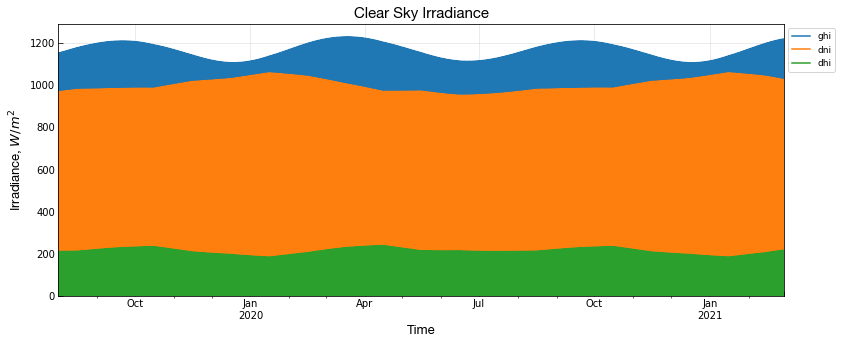

In [12]:
timeperiod = pd.date_range(start=start, end=end, freq='5min', tz=tz)

clearsky = location.get_clearsky(timeperiod)  #Ineichen by default
clearsky.drop(clearsky.tail(1).index,inplace=True)

#Plot
hor = 13
ver = 5

clearsky.plot(figsize=(hor,ver))

plt.title('Clear Sky Irradiance', fontname='Helvetica Neue', fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname='Helvetica Neue', fontsize=13);
plt.xlabel('Time', fontname='Helvetica Neue', fontsize=13);

plt.tick_params(direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.grid(True);
plt.tight_layout;

#plt.xlim(0, None)
plt.ylim(0, None)
plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);

In [13]:
#Append Clear Sky Irradiance to irrad dataframe
irrad['Clear Sky Irrad., W/m2'] = clearsky['ghi'].values

#Append Global Clearness Index (k) to irrad dataframe
k = irrad['Meteocontrol Irrad., W/m2'].values/clearsky['ghi'].values
irrad['Clearness Index'] = k

#Replace NaN with 1
irrad['Clearness Index'].fillna(1, inplace=True)

#Replace k > 1 values with 1
irrad.loc[irrad['Clearness Index'] > 1, 'Clearness Index'] = 1

In [14]:
irrad.head()

,Date,"Lufft Irrad., W/m2","Meteocontrol Irrad., W/m2",Year,Month,Day,Hour,Minute,"Clear Sky Irrad., W/m2",Clearness Index
0,2019-08-01 00:00:00,0.0,0.0,2019,8,1,0,0,0.0,1.0
1,2019-08-01 00:05:00,0.0,0.0,2019,8,1,0,5,0.0,1.0
2,2019-08-01 00:10:00,0.0,0.0,2019,8,1,0,10,0.0,1.0
3,2019-08-01 00:15:00,0.0,0.0,2019,8,1,0,15,0.0,1.0
4,2019-08-01 00:20:00,0.0,0.0,2019,8,1,0,20,0.0,1.0


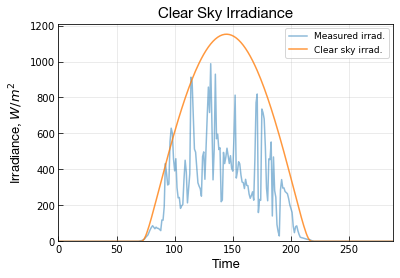

In [15]:
a = 0
b = a+300

#Plot
hor = 13
ver = 5

plt.plot(irrad['Meteocontrol Irrad., W/m2'][a:b].values, alpha=0.5, label='Measured irrad.')
plt.plot(clearsky['ghi'][a:b].values, alpha=0.8, label='Clear sky irrad.')

plt.title('Clear Sky Irradiance', fontname='Helvetica Neue', fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname='Helvetica Neue', fontsize=13);
plt.xlabel('Time', fontname='Helvetica Neue', fontsize=13);

plt.tick_params(direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.grid(True);
plt.tight_layout;

plt.xlim(0, 288)
plt.ylim(0, None)
plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);

#### 2.1.3. irrad_range: Function to extract an irradiance dataframe by datetime range

In [16]:
months_key = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [17]:
'''
irrad_range function extracts from the indicated dataframe 
those data included in the stipulated month and year.
'''

#Dictionary to save the dataframes from the function
data_dict = dict()

def irrad_range(year, month, dataframe):
    data = pd.DataFrame()
    
    #Extract data by year and month
    data = dataframe.loc[(dataframe['Year'] == year) & (dataframe['Month'] == months_key[month])]
    
    if data.empty:
        print('{}-{} does not exist in the database. Stored as None.'.format(month, year))
        data_dict['{}{}'.format(month, year)] = None
        
    if not data.empty:
        #Delete date breakdown columns (year, month, day, minute)
        #data.drop(['Year', 'Month', 'Day', 'Minute'], axis=1, inplace=True)

        #Create an 'Index' column for analysis purposes
        data['Index'] = range(0, len(data))    

        #Changing numerical-ordered index to datetime index
        data.set_index(data['Date'], inplace=True)
        data.drop(['Date'], axis=1, inplace=True)

        data_dict['{}{}'.format(month, year)] = data
    
    return(data_dict)

In [18]:
'''
irrad_range function example: extracting Jan-2021 data.
'''

#Selecting year and month to extract
year = 2021
month = 'Jan'

#irrad_range function
irrad_range(year=year, month=month, dataframe=irrad);
data_dict['{}{}'.format(month, year)].head()

,"Lufft Irrad., W/m2","Meteocontrol Irrad., W/m2",Year,Month,Day,Hour,Minute,"Clear Sky Irrad., W/m2",Clearness Index,Index
Date,,,,,,,,,,
2021-01-01 00:00:00,0.0,0.0,2021,1,1,0,0,0.0,1.0,0
2021-01-01 00:05:00,0.0,0.0,2021,1,1,0,5,0.0,1.0,1
2021-01-01 00:10:00,0.0,0.0,2021,1,1,0,10,0.0,1.0,2
2021-01-01 00:15:00,0.0,0.0,2021,1,1,0,15,0.0,1.0,3
2021-01-01 00:20:00,0.0,0.0,2021,1,1,0,20,0.0,1.0,4


#### 2.1.4. irrad_analysis: Function to extract max. and min.  irradiance from irrad_range dataframes

### Gráfica Apoyo Presentación

#### Se puede ver que hay variabilidad en la irradiancia entre los diferentes días para un mismo mes. Esto afianza la estocasticidad natural en los datos sintéticos.

In [19]:
'''
Plots set-up function.
'''

def plot_setup(setup, legend):
    if setup == True:
        hor = 13
        ver = 5
        plt.figure(figsize=(hor,ver))

        plt.tick_params(direction='in', length=5, width=0.75, grid_alpha=0.3)
        plt.xticks(rotation=0)
        plt.grid(True);
        plt.tight_layout;
    if legend == True:
        plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);
    else:
        None

In [20]:
'''
irrad_analysis function performs a statistical analysis in order
to extract max. and min. values for each data point. Also, the 
function calculates the median clearness index per day and
categorizes each day to one (of five) sky condition. 
'''

#Dictionary to save the dataframes from the function
analysis_dict = dict()
bootstrap_dict = dict() #Dictionary for Method 2.2: Bootstrap
skycond_dict = dict()
temp_skycond = dict()

def irrad_analysis(year, month, dictionary, plotall, plotskycond):
    #Array list to store daily irradiance values from irrad_range
    irrad = []
    irrads = []

    #Array list to store clearness index days
    totally_covered = []
    mostly_covered = []
    partly_covered = []
    mostly_clear = []
    totally_clear = []      
    
    #Calling the data from irrad_range dictionary previously created
    data = dictionary['{}{}'.format(month, year)]
    
    if data is None:
        print('The dataframe is empty.')
        analysis_dict['{}{}'.format(month, year)] = None
    
    if data is not None:
        #Extracting the days from the data from irrad_range dictionary
        days = data['Day'].unique()

        #Extract time to set the plot xlabel
        times = []
        for i in range(0, len(data)):
            day = 1
            if data['Day'].values[i] == day:
                hour = data.index[i].hour
                minute = data.index[i].minute

                if minute < 10:
                    time_format = '{}:0{}'.format(hour, minute)
                else:    
                    time_format = '{}:{}'.format(hour, minute)
                times.append(time_format)

        #Plot set-up
        plot_setup(setup=True, legend=False)

        #Loop to extract daily irradiance values
        for i in days:
            '''
            Clearness index daily categorization into five sky conditions (SC)
            '''
            data_daily = data.loc[data['Day'] == i]

            '''
            Clearness index (k) analysis: mean daily values which are categorized as follows:
            - Sky Condition 1 (SC1): Totally covered, when k <= 0.2
            - Sky Condition 2 (SC2): Mostly covered, when 0.2 < k <= 0.4
            - Sky Condition 3 (SC3): Partly covered, when 0.4 < k <= 0.6
            - Sky Condition 4 (SC4): Mostly clear, when 0.6 < k <= 0.67
            - Sky Condition 5 (SC5): Totally clear, when k > 0.67 
            '''
            #Median value of clearness index (k) between 6:00 to 18:00 h range
            range_k = data_daily.loc[(data_daily['Hour'] >= 6) & (data_daily['Hour'] < 18)]
            median_k = range_k['Clearness Index'].median()

            #Categorization according to clearness index value
            if median_k <= 0.2:
                totally_covered.append(i)
            if (0.2 < median_k and median_k <= 0.4):
                mostly_covered.append(i)
            if (0.4 < median_k and median_k <= 0.6):
                partly_covered.append(i)
            if (0.6 < median_k and median_k <= 0.67):
                mostly_clear.append(i)        
            if median_k > 0.67:
                totally_clear.append(i)

        #Dictionary clearness index analysis add
        skycond_dict['{}{}-SC1'.format(month, year)] = totally_covered
        skycond_dict['{}{}-SC2'.format(month, year)] = mostly_covered
        skycond_dict['{}{}-SC3'.format(month, year)] = partly_covered
        skycond_dict['{}{}-SC4'.format(month, year)] = mostly_clear
        skycond_dict['{}{}-SC5'.format(month, year)] = totally_clear

        #Loop to extract all daily irradiance values
        for i in days:
            '''
            Data analysis:
            1. Extraction of daily dataframes from data_dict (irrad_range function) according to the SC
            2. Extraction of irradiance values from above step.
            3. Statistical analysis for each data-point (time) for all days of the month selected (Step 1 to 4)
            '''
            data_daily = data.loc[data['Day'] == i]

            '''
            1. Complete analysis: all days within the month
            '''
            irrad.append(data_daily['Meteocontrol Irrad., W/m2'].values)   

            #Step 1: Create an identical irrad dataframe to work on and set time as column names
            step1 = pd.DataFrame(irrad)
            step1.columns = times

            bootstrap_dict['{}{}'.format(month, year)] = step1.transpose()

            #Step 2: Description of all data-points for the anaylized days
            step2 = step1.describe()

            #Step 3: Transposition of dataframe (Setting timestamps as index and days as column names)
            step3 = step2.transpose()

            #Step 4: Save the analysis in analysis_dict
            analysis_dict['{}{}'.format(month, year)] = step3

            '''
            Plot of the statistical analysis done
            '''
            #Plot
            if plotall != False:
                plt.plot(irrad[i-1], alpha=0.1, linewidth=0.5, linestyle='--', marker='.', fillstyle='none')

                if i==days[-1]:
                    plt.fill_between(x=np.arange(len(irrad[i-1])), 
                                     y1=step3['max'], 
                                     y2=step3['min'], 
                                     color='whitesmoke', alpha=0.35, label='Stochastic range')

                    step3['max'].plot(color='#1580E4', marker='.', linestyle='')
                    step3['mean'].plot(color='#2DBD07', marker='.', linestyle='')
                    step3['min'].plot(color='coral', marker='.', linestyle='')

                    plt.title('Irradiance Behaviour for {}-{}'.format(month, year), fontname='Helvetica Neue', fontsize=15);
                    plt.ylabel('Irradiance, $W/m^2$', fontname='Helvetica Neue', fontsize=13);
                    plt.xlabel('Time', fontname='Helvetica Neue', fontsize=13);

                    plt.xlim(0, len(irrad[i-1]))
                    plt.ylim(0, None)
                    plt.grid(True)
                    plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);
                    if plotall == False:
                        plt.close()

        #Loop to extract all sky condition irradiance values
        skyconds = {'SC1': 'Totally covered', 
                    'SC2': 'Mostly covered', 
                    'SC3': 'Partly covered', 
                    'SC4': 'Mostly clear', 
                    'SC5': 'Totally clear'}

        for i in skyconds.keys():
            '''
            Data analysis same as above
            '''
            skycond_array = data[data['Day'].isin(skycond_dict['{}{}-{}'.format(month, year, i)])]
            
            temp_skycond['{}{}-{}'.format(month, year, i)] = skycond_array
            
            irrads = []
            if len(skycond_array)==0:
                analysis_dict['{}{}-{}'.format(month, year, i)] = None
                bootstrap_dict['{}{}-{}'.format(month, year, i)] = None
            if len(skycond_array)!=0:
                #Extracting the days from the data from irrad_range dictionary
                days = skycond_array['Day'].unique()

                for j in skycond_dict['{}{}-{}'.format(month, year, i)]:
                    data_daily = skycond_array.loc[skycond_array['Day'] == j]

                    irrads.append(data_daily['Meteocontrol Irrad., W/m2'].values)   

                #Step 1: Create an identical irrad dataframe to work on and set time as column names
                step1 = pd.DataFrame(irrads)
                step1.columns = times

                bootstrap_dict['{}{}-{}'.format(month, year, i)] = step1.transpose()

                #Step 2: Description of all data-points for the anaylized days
                step2 = step1.describe()

                #Step 3: Transposition of dataframe (Setting timestamps as index and days as column names)
                step3 = step2.transpose()

                #Step 4: Save the analysis in analysis_dict
                analysis_dict['{}{}-{}'.format(month, year, i)] = step3

                '''
                Plot of the statistical analysis done
                '''
                #Plot set-up
                if plotskycond != False:                
                    plt.figure()
                    plot_setup(setup=True, legend=False)

                    for j in skycond_dict['{}{}-{}'.format(month, year, i)]:
                        #Plot
                        data_daily = skycond_array.loc[skycond_array['Day'] == j]
                        plt.plot(data_daily['Meteocontrol Irrad., W/m2'].values, alpha=0.1, linewidth=0.5, 
                                 linestyle='--', marker='.', fillstyle='none')
                        if j==days[-1]:
                            plt.fill_between(x=np.arange(len(step3)), 
                                             y1=step3['max'], 
                                             y2=step3['min'], 
                                             color='whitesmoke', alpha=0.35, label='Stochastic range')

                            step3['max'].plot(color='#1580E4', marker='.', linestyle='')
                            step3['mean'].plot(color='#2DBD07', marker='.', linestyle='')
                            step3['min'].plot(color='coral', marker='.', linestyle='')

                            plt.title('Irradiance Behaviour for {}-{} ({})'.format(month, year, skyconds[i]), 
                                      fontname='Helvetica Neue', fontsize=15)
                            plt.ylabel('Irradiance, $W/m^2$', fontname='Helvetica Neue', fontsize=13)
                            plt.xlabel('Time', fontname='Helvetica Neue', fontsize=13)

                            plt.xlim(0, len(step3))
                            plt.ylim(0, None)
                            plt.grid(True)
                            plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);
                            if plotskycond == False:
                                plt.close()
            
    return(analysis_dict)

{'Jan2021':        count  mean  std  min  25%  50%  75%  max
 0:00    31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0:05    31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0:10    31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0:15    31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0:20    31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ...      ...   ...  ...  ...  ...  ...  ...  ...
 23:35   31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 23:40   31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 23:45   31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 23:50   31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 23:55   31.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 
 [288 rows x 8 columns],
 'Jan2021-SC1': None,
 'Jan2021-SC2':        count  mean  std  min  25%  50%  75%  max
 0:00    12.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0:05    12.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0:10    12.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0:15    12.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0:20    12.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ...      ...   ...  ... 

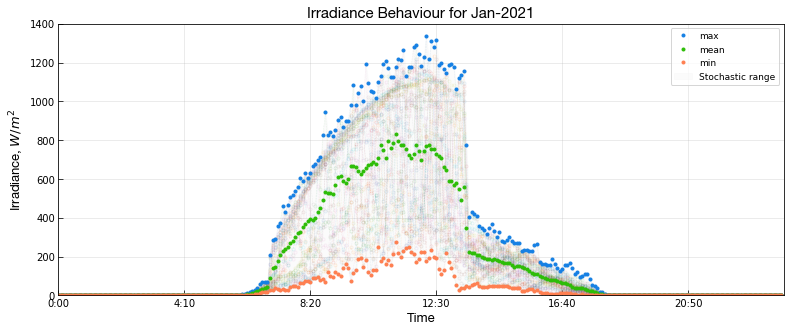

<Figure size 432x288 with 0 Axes>

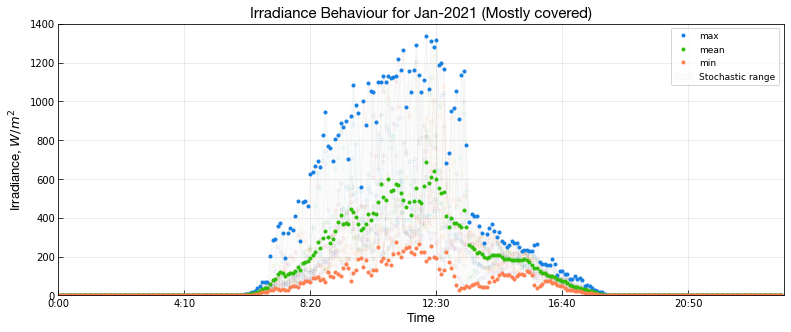

<Figure size 432x288 with 0 Axes>

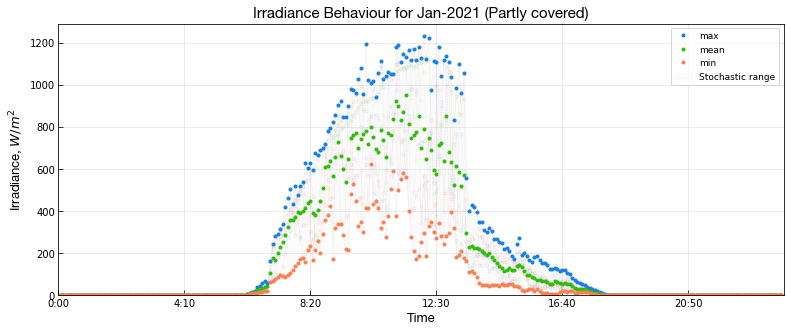

<Figure size 432x288 with 0 Axes>

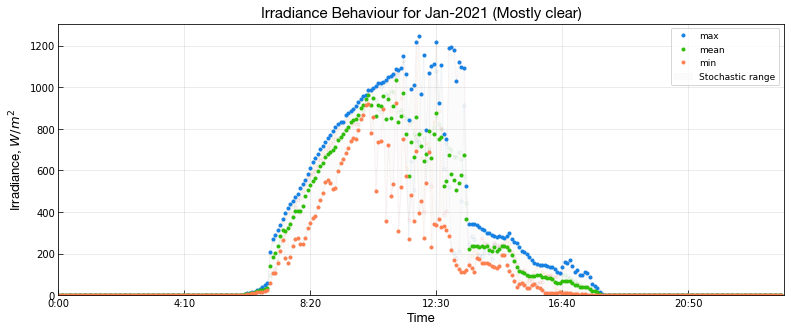

<Figure size 432x288 with 0 Axes>

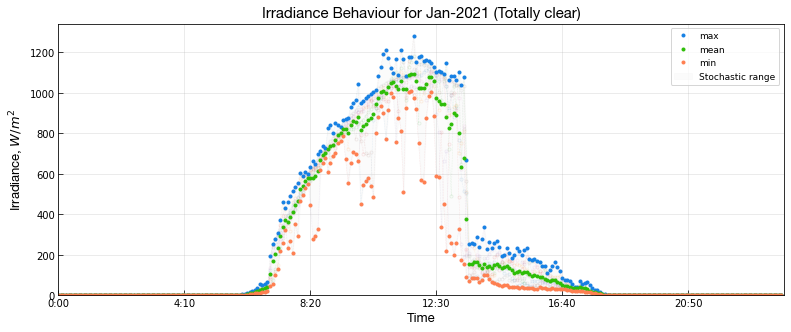

In [21]:
'''
irrad_analysis function example: analysing Jan-2021 data.
'''
#Selecting year and month to extract
year = 2021
month = 'Jan'

#irrad_analysis function
irrad_analysis(year=year, month=month, dictionary=data_dict, plotall=True, plotskycond=True);
analysis_dict

#### 2.1.5. irradsynt_m1 function generates synthetic irradiance data points from stochastic method

In [22]:
'''
irradsynt_m1 function generates synthetic irradiance data points according 
to the statistical analysis generated by irrad_analysis function. The 
extension '_m1' refers to Method 1: Stochastic (Montecarlo).
'''

#Dictionary to save the dataframes from the function
irradsyntm1_dict = dict()
        
def irradsynt_m1(year, month, skycond, dictionary, runs):
    #Calling the data from irrad_analysis dictionary previously created
    data = dictionary['{}{}-{}'.format(month, year, skycond)]
    
    if data is None:
        print('The dataframe is empty.')
        irradsyntm1_dict['{}{}-{}'.format(month, year, skycond)] = None
    
    if data is not None:
        #DataFrame to store all the synthetic irradiance before store at dictionary
        synt_df = pd.DataFrame()

        '''
        Outer for loop is to generate scenarios as stated by runs parameter. Inner for loop is 
        to to generate one-scenario dataset, i.e., 288 data points for 5-min resolution day.
        '''
        for i in range(0, runs):
            #Array list to store daily irradiance values from irrad_analysis
            irradsynt = []

            for j in range(0, len(data)):
                #Extraction of description analysis for one data point (j)
                datapoint = data.loc[data.index == data.index[j]]

                #Generation of synthetic irradiance by a gaussian (normal) distribution
                #random.seed(i)
                synt = np.random.normal(loc=datapoint['mean'], scale=datapoint['std'])[0]
                if synt < datapoint['min'][0]:
                    synt = datapoint['min'][0]
                if synt > datapoint['max'][0]:
                    synt = datapoint['max'][0]

                #One day irradiance synthetic data storage
                irradsynt.append(synt)

            #Synthetic data storage in dataframe
            synt_df['Synt {}'.format(i)] = irradsynt

            if i == runs-1:            
                #Change numerical index to datetime index
                synt_df.set_index(data.index, inplace=True)

                #Save the synthetic data in irradsyntm1_dict
                irradsyntm1_dict['{}{}-{}'.format(month, year, skycond)] = synt_df 
 
    return(irradsyntm1_dict)

In [23]:
'''
irradsynt_m1 function example: generating synthetic irradiance for Jan-2021 data.
'''

#Selecting year and month to extract
year = 2021
month = 'Jan'
skycond = 'SC5'
runs=5

#irrad_analysis function
irradsynt_m1(year=year, month=month, skycond=skycond, dictionary=analysis_dict, runs=runs);
irradsyntm1_dict['{}{}-{}'.format(month, year, skycond)]

,Synt 0,Synt 1,Synt 2,Synt 3,Synt 4
0:00,0.0,0.0,0.0,0.0,0.0
0:05,0.0,0.0,0.0,0.0,0.0
0:10,0.0,0.0,0.0,0.0,0.0
0:15,0.0,0.0,0.0,0.0,0.0
0:20,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
23:35,0.0,0.0,0.0,0.0,0.0
23:40,0.0,0.0,0.0,0.0,0.0
23:45,0.0,0.0,0.0,0.0,0.0
23:50,0.0,0.0,0.0,0.0,0.0


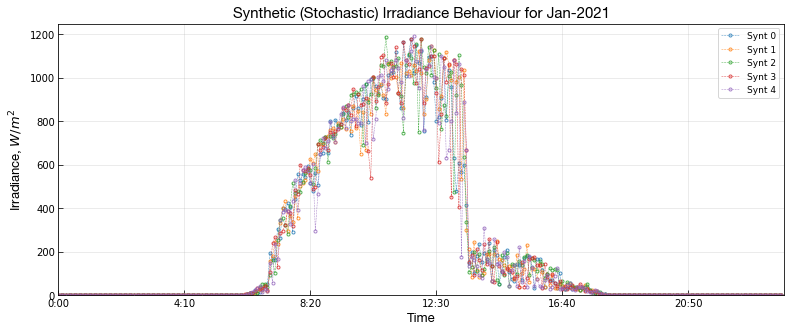

In [24]:
'''
irradsynt_m1 example plot.
'''
hor = 13
ver = 5
legend = True

irradsyntm1_dict['{}{}-{}'.format(month, year, skycond)].plot(alpha=0.8, linewidth=0.5, linestyle='--', marker='.',
                                                fillstyle='none', figsize=(hor,ver), legend=legend)

plt.title('Synthetic (Stochastic) Irradiance Behaviour for {}-{}'.format(month, year), 
          fontname='Helvetica Neue', fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname='Helvetica Neue', fontsize=13);
plt.xlabel('Time', fontname='Helvetica Neue', fontsize=13);

plt.tick_params(direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.grid(True);
plt.tight_layout;

plt.xlim(0, len(irradsyntm1_dict['{}{}-{}'.format(month, year, skycond)]))
plt.ylim(0, None)
if legend==True:
    plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);

### 2.2. Method 2: Stochastic (Bootstrap)

#### 2.2.1. irradsynt_m2 function generates synthetic irradiance data points from bootstrap method

In [25]:
'''
irradsynt_m2 function generates synthetic irradiance data points according 
to the statistical analysis generated by irrad_analysis function. The 
extension '_m2' refers to Method 2: Bootstrap (Montecarlo).
'''

#Dictionary to save the dataframes from the function
irradsyntm2_dict = dict()
        
def irradsynt_m2(year, month, skycond, dictionary, runs):
    #Calling the data from irrad_analysis dictionary previously created
    data = dictionary['{}{}-{}'.format(month, year, skycond)]
    
    if data is None:
        print('The dataframe is empty.')
        irradsyntm2_dict['{}{}-{}'.format(month, year, skycond)] = None
        
    if data is not None:
        #DataFrame to store all the synthetic irradiance before store at dictionary
        synt_df = pd.DataFrame()

        '''
        Outer for loop is to generate scenarios as stated by runs parameter. Inner for loop is 
        to to generate one-scenario dataset, i.e., 288 data points for 5-min resolution day.
        '''
        for i in range(0, runs):
            #Array list to store daily irradiance values from irrad_analysis
            irradsynt = []

            for j in range(0, len(data)):
                #Extraction of description analysis for one data point (j)
                datapoint = data.loc[data.index == data.index[j]]

                #Generation of synthetic irradiance by a selecting an existing value whitin the range
                boost_column = random.choice(datapoint.columns.tolist()) #Random column selection
                synt = datapoint.loc[datapoint.index == datapoint.index[0]][boost_column][0]

                #One day irradiance synthetic data storage
                irradsynt.append(synt)

            #Synthetic data storage in dataframe
            synt_df['Synt {}'.format(i)] = irradsynt

            if i == runs-1:            
                #Change numerical index to datetime index
                synt_df.set_index(data.index, inplace=True)

                #Save the synthetic data in irradsyntm1_dict
                irradsyntm2_dict['{}{}-{}'.format(month, year, skycond)] = synt_df 
 
    return(irradsyntm2_dict)

In [26]:
'''
irradsynt_m2 function example: generating synthetic irradiance for Jan-2021 data.
'''

#Selecting year and month to extract
year = 2021
month = 'Jan'
skycond = 'SC5'
runs=5

#irrad_analysis function
irradsynt_m2(year=year, month=month, skycond=skycond, dictionary=bootstrap_dict, runs=runs);
irradsyntm2_dict['{}{}-{}'.format(month, year, skycond)].head()

,Synt 0,Synt 1,Synt 2,Synt 3,Synt 4
0:00,0.0,0.0,0.0,0.0,0.0
0:05,0.0,0.0,0.0,0.0,0.0
0:10,0.0,0.0,0.0,0.0,0.0
0:15,0.0,0.0,0.0,0.0,0.0
0:20,0.0,0.0,0.0,0.0,0.0


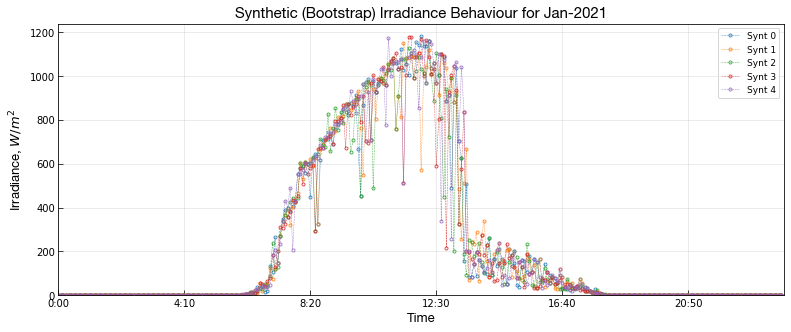

In [27]:
'''
irradsynt_m2 example plot.
'''
hor = 13
ver = 5
legend = True

irradsyntm2_dict['{}{}-{}'.format(month, year, skycond)].plot(alpha=0.8, linewidth=0.5, linestyle='--', marker='.',
                                                fillstyle='none', figsize=(hor,ver), legend=legend)

plt.title('Synthetic (Bootstrap) Irradiance Behaviour for {}-{}'.format(month, year), 
          fontname='Helvetica Neue', fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname='Helvetica Neue', fontsize=13);
plt.xlabel('Time', fontname='Helvetica Neue', fontsize=13);

plt.tick_params(direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.grid(True);
plt.tight_layout;

plt.xlim(0, len(irradsyntm2_dict['{}{}-{}'.format(month, year, skycond)]))
plt.ylim(0, None)
if legend==True:
    plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);

In [28]:
irradsyntm2_dict

{'Jan2021-SC5':        Synt 0  Synt 1  Synt 2  Synt 3  Synt 4
 0:00      0.0     0.0     0.0     0.0     0.0
 0:05      0.0     0.0     0.0     0.0     0.0
 0:10      0.0     0.0     0.0     0.0     0.0
 0:15      0.0     0.0     0.0     0.0     0.0
 0:20      0.0     0.0     0.0     0.0     0.0
 ...       ...     ...     ...     ...     ...
 23:35     0.0     0.0     0.0     0.0     0.0
 23:40     0.0     0.0     0.0     0.0     0.0
 23:45     0.0     0.0     0.0     0.0     0.0
 23:50     0.0     0.0     0.0     0.0     0.0
 23:55     0.0     0.0     0.0     0.0     0.0
 
 [288 rows x 5 columns]}

### 2.3. Montecarlo Synthetic Data Generation

#### 2.3.1. irrad_montecarlo: Function to generate synthetic irradiance from the real time window

In [29]:
'''
Here is the breakdown of the total number of synthetic scenarios to be generated:
1. n_total: 5.000 scenarios for each month (60.000 total)
2. n_m1: 50% are generated by Method 1: Stochastic (Montecarlo), i.e. 2.500 per month.
3. n_m2: 50% are generated by Method 2: Bootstrap, i.e. 2.500 per month.
'''
#Total number of synthetic scenarios
n_total = 5000
splits = 5
n_batch = n_total/splits

#Number of synthetic scenarios for each method (m1, m2 and m3)
n_m1 = n_batch*0.5
n_m2 = n_batch*0.5

In [30]:
meas_irrad.head()

,Date,"Lufft Irrad., W/m2","Meteocontrol Irrad., W/m2",Year,Month,Day,Hour,Minute,"Clear Sky Irrad., W/m2",Clearness Index
0,2019-08-01 00:00:00,0.0,0.0,2019,8,1,0,0,0.0,1.0
1,2019-08-01 00:05:00,0.0,0.0,2019,8,1,0,5,0.0,1.0
2,2019-08-01 00:10:00,0.0,0.0,2019,8,1,0,10,0.0,1.0
3,2019-08-01 00:15:00,0.0,0.0,2019,8,1,0,15,0.0,1.0
4,2019-08-01 00:20:00,0.0,0.0,2019,8,1,0,20,0.0,1.0


In [31]:
'''
irradsynt_montecarlo function generates synthetic irradiance data points according 
to the statistical analysis generated by irrad_analysis function.
'''

#Dictionary to save the dataframes from the function
synt_irrad = pd.DataFrame()
synt_m1 = pd.DataFrame()
synt_m2 = pd.DataFrame()       

def irrad_montecarlo(years, months, data, runs_m1, runs_m2, firstiter, plot):    
    '''
    Clean the dictionaries that store the data
    '''
    if firstiter is True:
        data_dict.clear()
        analysis_dict.clear()
        skycond_dict.clear()
        bootstrap_dict.clear()
        irradsyntm1_dict.clear()
        irradsyntm2_dict.clear()
    
    '''
    Outer loop to go through the years. Inner loop to go through the years. 
    Other loops are to go through the sky conditions and the two synthetic
    data generation methods: i. stochastic and ii. boostrap.
    '''
    if plot is False:                
        dates = []
        for year in years:
            for month in months:
                date = '{}{}'.format(month, year)
                dates.append(date)
        
        for date in tqdm(dates, desc='Synt. Gen.', leave=True):
            month = date[0:3]
            year = int(date[3:7])
            
            #Step 1: Extract dataframe according to date
            irrad_range(year=year, month=month, dataframe=data);
              
            #Step 2: Statistical analysis of dataframe from Step 1
            irrad_analysis(year=year, month=month, dictionary=data_dict, plotall=False, plotskycond=False);
            plt.close()
             
            #Step 3: Generate synthetic data with Method 1 and 2
            skyconds = {'SC1': 0, 'SC2': 0, 'SC3': 0, 'SC4': 0, 'SC5': 0}

            ## Number of days of the date
            analysis_df = analysis_dict['{}{}'.format(month, year)]
            if analysis_df is not None:
                total = analysis_df['count'][0]
            
            ## Method 1 
            ### Number of days of the date categorized by sky condition
            for sc in skyconds.keys():
                check_none = analysis_dict['{}{}'.format(month, year)]
                if check_none is not None:
                    df = analysis_dict['{}{}-{}'.format(month, year, sc)]
                    if df is None:
                        skyconds['{}'.format(sc)] = 0
                    if df is not None:
                        skyconds['{}'.format(sc)] = df['count'][0]

            for sc in tqdm(skyconds.keys(), desc='Method 1', leave=False):
                calc = (skyconds['{}'.format(sc)]/total)*100*runs_m1
                calc = np.around(calc, decimals=0)
                skyconds['{}'.format(sc)] = int(calc)
                    
                runs = skyconds['{}'.format(sc)]
                if runs!=0:
                    irradsynt_m1(year=year, month=month, skycond=sc, 
                                 dictionary=analysis_dict, runs=runs);
                plt.close()
            
            ## Method 2
            ### Number of days of the date categorized by sky condition
            for sc in skyconds.keys():
                check_none = analysis_dict['{}{}'.format(month, year)]
                if check_none is not None:
                    df = analysis_dict['{}{}-{}'.format(month, year, sc)]
                    if df is None:
                        skyconds['{}'.format(sc)] = 0
                    if df is not None:
                        skyconds['{}'.format(sc)] = df['count'][0]

            for sc in tqdm(skyconds.keys(), desc='Method 2', leave=False):
                calc = (skyconds['{}'.format(sc)]/total)*100*runs_m2
                calc = np.around(calc, decimals=0)
                skyconds['{}'.format(sc)] = int(calc)
                    
                runs = skyconds['{}'.format(sc)]
                if runs!=0:
                    irradsynt_m2(year=year, month=month, skycond=sc, 
                                 dictionary=bootstrap_dict, runs=runs);
                plt.close()
            
    return(irradsyntm1_dict, irradsyntm2_dict)

In [32]:
'''
irrad_montecarlo function example: generating synthetic irradiance for Aug-2019 to Feb-2021 data.
'''

#Selecting year and month to extract
years = meas_irrad['Year'].unique()

months = []
for i in meas_irrad['Month'].unique():
    for month, j in months_key.items():
        if i == j:
            months.append(month)

#irrad_analysis function
irrad_montecarlo(years=years, months=months, data=meas_irrad, runs_m1=0.1, runs_m2=0.1, firstiter=True, plot=False);

Jan-2019 does not exist in the database. Stored as None.
The dataframe is empty.


Feb-2019 does not exist in the database. Stored as None.
The dataframe is empty.


Mar-2019 does not exist in the database. Stored as None.
The dataframe is empty.


Apr-2019 does not exist in the database. Stored as None.
The dataframe is empty.


May-2019 does not exist in the database. Stored as None.
The dataframe is empty.


Jun-2019 does not exist in the database. Stored as None.
The dataframe is empty.


Jul-2019 does not exist in the database. Stored as None.
The dataframe is empty.


Aug-2021 does not exist in the database. Stored as None.
The dataframe is empty.


Sep-2021 does not exist in the database. Stored as None.
The dataframe is empty.


Oct-2021 does not exist in the database. Stored as None.
The dataframe is empty.


Nov-2021 does not exist in the database. Stored as None.
The dataframe is empty.


Dec-2021 does not exist in the database. Stored as None.
The dataframe is empty.


Mar-2021 does not exist in the database. Stored as None.
The dataframe is empty.


Apr-2021 does not exist in the database. Stored as None.
The dataframe is empty.


May-2021 does not exist in the database. Stored as None.
The dataframe is empty.


Jun-2021 does not exist in the database. Stored as None.
The dataframe is empty.


Jul-2021 does not exist in the database. Stored as None.
The dataframe is empty.


In [33]:
irradsyntm1_dict

{'Aug2019-SC1':        Synt 0
 0:00      0.0
 0:05      0.0
 0:10      0.0
 0:15      0.0
 0:20      0.0
 ...       ...
 23:35     0.0
 23:40     0.0
 23:45     0.0
 23:50     0.0
 23:55     0.0
 
 [288 rows x 1 columns],
 'Aug2019-SC2':        Synt 0  Synt 1  Synt 2  Synt 3  Synt 4  Synt 5
 0:00      0.0     0.0     0.0     0.0     0.0     0.0
 0:05      0.0     0.0     0.0     0.0     0.0     0.0
 0:10      0.0     0.0     0.0     0.0     0.0     0.0
 0:15      0.0     0.0     0.0     0.0     0.0     0.0
 0:20      0.0     0.0     0.0     0.0     0.0     0.0
 ...       ...     ...     ...     ...     ...     ...
 23:35     0.0     0.0     0.0     0.0     0.0     0.0
 23:40     0.0     0.0     0.0     0.0     0.0     0.0
 23:45     0.0     0.0     0.0     0.0     0.0     0.0
 23:50     0.0     0.0     0.0     0.0     0.0     0.0
 23:55     0.0     0.0     0.0     0.0     0.0     0.0
 
 [288 rows x 6 columns],
 'Aug2019-SC3':        Synt 0  Synt 1
 0:00      0.0     0.0
 0:05      0.0 

In [34]:
irradsyntm2_dict

{'Aug2019-SC1':        Synt 0
 0:00      0.0
 0:05      0.0
 0:10      0.0
 0:15      0.0
 0:20      0.0
 ...       ...
 23:35     0.0
 23:40     0.0
 23:45     0.0
 23:50     0.0
 23:55     0.0
 
 [288 rows x 1 columns],
 'Aug2019-SC2':        Synt 0  Synt 1  Synt 2  Synt 3  Synt 4  Synt 5
 0:00      0.0     0.0     0.0     0.0     0.0     0.0
 0:05      0.0     0.0     0.0     0.0     0.0     0.0
 0:10      0.0     0.0     0.0     0.0     0.0     0.0
 0:15      0.0     0.0     0.0     0.0     0.0     0.0
 0:20      0.0     0.0     0.0     0.0     0.0     0.0
 ...       ...     ...     ...     ...     ...     ...
 23:35     0.0     0.0     0.0     0.0     0.0     0.0
 23:40     0.0     0.0     0.0     0.0     0.0     0.0
 23:45     0.0     0.0     0.0     0.0     0.0     0.0
 23:50     0.0     0.0     0.0     0.0     0.0     0.0
 23:55     0.0     0.0     0.0     0.0     0.0     0.0
 
 [288 rows x 6 columns],
 'Aug2019-SC3':        Synt 0  Synt 1
 0:00      0.0     0.0
 0:05      0.0 

### 2.4. Synthetic Data Download

#### 2.4.1. Synthetic data download generated by Method 1 (just for code test)

In [35]:
'''
Method 1
'''
keys = list(irradsyntm1_dict.keys())

for data in keys:
    csv_name = '{}.csv'.format(data)
    df = irradsyntm1_dict[data]
    
    if df is not None:
        field_names = irradsyntm1_dict[data].columns
        file_name = './CSV Files/Test/{}.csv'.format(data)
        df.to_csv(file_name, header=True, index=True, index_label='Index', decimal='.')

#### 2.4.2. Code to download the synthetic data in Google Colab:

```python
'''
Method 1
'''
keys = list(irradsyntm1_dict.keys())
iter = 'Iter_10'

for data in keys:
    csv_name = '{}.csv'.format(data)
    df = irradsyntm1_dict[data]
    
    if df is not None:
        field_names = irradsyntm1_dict[data].columns
        file_name = '/content/drive/MyDrive/Tesis/Synt/Method_1/{}/{}.csv'.format(iter, data)
        df.to_csv(file_name, header=True, index=True, decimal='.')
        
'''
Method 2
'''
keys = list(irradsyntm2_dict.keys())
iter = 'Iter_10'

for data in keys:
    csv_name = '{}.csv'.format(data)
    df = irradsyntm2_dict[data]
    
    if df is not None:
        field_names = irradsyntm2_dict[data].columns
        file_name = '/content/drive/MyDrive/Tesis/Synt/Method_2/{}/{}.csv'.format(iter, data)
        df.to_csv(file_name, header=True, index=True, decimal='.')
```

#### 2.4.3. temp_skycond data download

In [105]:
temp_skycond

{'Jan2021-SC1': Empty DataFrame
 Columns: [Lufft Irrad., W/m2, Meteocontrol Irrad., W/m2, Year, Month, Day, Hour, Minute, Clear Sky Irrad., W/m2, Clearness Index, Index]
 Index: [],
 'Jan2021-SC2':                      Lufft Irrad., W/m2  Meteocontrol Irrad., W/m2  Year  \
 Date                                                                       
 2021-01-01 00:00:00                 0.0                        0.0  2021   
 2021-01-01 00:05:00                 0.0                        0.0  2021   
 2021-01-01 00:10:00                 0.0                        0.0  2021   
 2021-01-01 00:15:00                 0.0                        0.0  2021   
 2021-01-01 00:20:00                 0.0                        0.0  2021   
 ...                                 ...                        ...   ...   
 2021-01-25 23:35:00                 0.0                        0.0  2021   
 2021-01-25 23:40:00                 0.0                        0.0  2021   
 2021-01-25 23:45:00             

In [106]:
'''
temp_skycond download for Section 3 ease to use
'''
keys = list(temp_skycond.keys())

for data in keys:
    csv_name = '{}.csv'.format(data)
    df = temp_skycond[data]
    
    if df is not None:
        field_names = temp_skycond[data].columns
        file_name = './CSV Files/temp_skycond/{}.csv'.format(data)
        df.to_csv(file_name, header=True, index=True, index_label='Index', decimal='.')

# 3. $T_{amb}$ and $T_{mod}$ Synthetic Data Generation

### 3.1. Data Import

In [36]:
file_name = './Meteocontrol/SD_5Min.xlsx'

#Meteocontrol Irradiance Measurement
sheet = 'Temperatura'
temp = pd.read_excel(io=file_name, sheet_name=sheet)
temp = pd.DataFrame(temp)

In [37]:
#Replace NaN with 0
temp['Tmod, ºC'].fillna(0, inplace=True)
temp['Tamb, ºC'].fillna(0, inplace=True)

temp.head()

,Date,"Tmod, ºC","Tamb, ºC"
0,2019-08-01 00:00:00,11.479701,11.479701
1,2019-08-01 00:05:00,11.451553,11.451553
2,2019-08-01 00:10:00,11.456052,11.456052
3,2019-08-01 00:15:00,11.417488,11.417488
4,2019-08-01 00:20:00,11.345733,11.345733


#### 3.1.1. Date breakdown: year, month, day, minute

In [38]:
years = []
months = []
days = []
hours = []
mins = []

for i in range(0, len(temp)):
    date = temp['Date'][i]
    
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    hours.append(date.hour)
    mins.append(date.minute)
    
temp['Year'], temp['Month'], temp['Day'], temp['Hour'], temp['Minute'] = [years, months, days, hours, mins]

In [39]:
#Back-up dataframe
meas_temp = temp

temp.head()

,Date,"Tmod, ºC","Tamb, ºC",Year,Month,Day,Hour,Minute
0,2019-08-01 00:00:00,11.479701,11.479701,2019,8,1,0,0
1,2019-08-01 00:05:00,11.451553,11.451553,2019,8,1,0,5
2,2019-08-01 00:10:00,11.456052,11.456052,2019,8,1,0,10
3,2019-08-01 00:15:00,11.417488,11.417488,2019,8,1,0,15
4,2019-08-01 00:20:00,11.345733,11.345733,2019,8,1,0,20


In [40]:
meas_irrad.head()

,Date,"Lufft Irrad., W/m2","Meteocontrol Irrad., W/m2",Year,Month,Day,Hour,Minute,"Clear Sky Irrad., W/m2",Clearness Index
0,2019-08-01 00:00:00,0.0,0.0,2019,8,1,0,0,0.0,1.0
1,2019-08-01 00:05:00,0.0,0.0,2019,8,1,0,5,0.0,1.0
2,2019-08-01 00:10:00,0.0,0.0,2019,8,1,0,10,0.0,1.0
3,2019-08-01 00:15:00,0.0,0.0,2019,8,1,0,15,0.0,1.0
4,2019-08-01 00:20:00,0.0,0.0,2019,8,1,0,20,0.0,1.0


#### 3.1.2. temp_range: Function to extract a temperature dataframe by datetime range

In [41]:
'''
temp_range function extracts from the indicated dataframe 
those data included in the stipulated month and year.
'''

#Dictionary to save the dataframes from the function
temp_dict = dict()

def temp_range(year, month, dataframe):
    data = pd.DataFrame()
    
    #Extract data by year and month
    data = dataframe.loc[(dataframe['Year'] == year) & (dataframe['Month'] == months_key[month])]
    
    if data.empty:
        print('{}-{} does not exist in the database. Stored as None.'.format(month, year))
        temp_dict['{}{}'.format(month, year)] = None
        
    if not data.empty:
        #Create an 'Index' column for analysis purposes
        data['Index'] = range(0, len(data))    

        #Changing numerical-ordered index to datetime index
        data.set_index(data['Date'], inplace=True)
        data.drop(['Date'], axis=1, inplace=True)

        temp_dict['{}{}'.format(month, year)] = data
    
    return(temp_dict)

In [42]:
'''
temp_range function example: extracting Jan-2021 temperature data.
'''

#Selecting year and month to extract
year = 2021
month = 'Jan'

#irrad_range function
temp_range(year=year, month=month, dataframe=temp);
temp_dict['{}{}'.format(month, year)].head()

,"Tmod, ºC","Tamb, ºC",Year,Month,Day,Hour,Minute,Index
Date,,,,,,,,
2021-01-01 00:00:00,12.268,23.759,2021,1,1,0,0,0
2021-01-01 00:05:00,12.220,23.603,2021,1,1,0,5,1
2021-01-01 00:10:00,12.436,23.979,2021,1,1,0,10,2
2021-01-01 00:15:00,12.418,23.848,2021,1,1,0,15,3
2021-01-01 00:20:00,12.318,23.658,2021,1,1,0,20,4


#### 3.1.3. temp_est: Function to estimate $T_{amb}$ and $T_{mod}$  for each synthetic irradiance data point

In [43]:
'''
Download the dict keys (e.g. Aug2019-SC1) 
to avoid running the complete code
'''
keys = list(irradsyntm1_dict.keys())

with open('keys.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(keys)

In [44]:
'''
Upload the dict keys (e.g. Aug2019-SC1) previouly
downloaded to avoid running the complete code
'''
file_name = './CSV Files/Test/keys.csv'

with open(file_name, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    for line in csv_reader:
        keys = line

In [45]:
'''
Show uploaded keys
'''
keys[0:5]

['Aug2019-SC1', 'Aug2019-SC2', 'Aug2019-SC3', 'Aug2019-SC5', 'Sep2019-SC1']

In [46]:
'''
1. Upload the downloaded synthetic data generated by irrad_montecarlo function
2. Create a dict to store the data (pvlib_dict that will store dicts)
3. The stored dicts in pvlib_dict are for each sky condition (e.g. Aug2019-SC1)
4. Each sky condition dict into the pvlib_dict contain each synthetic irradiance separatley

Output: pvlib_dict that contain sky condition dicts that contain synthetic irrad. separately,
e.g.: pvlib_dict['Aug2019-SC1']['Synt 0'] returns the dataframe for Synt 0 synthetic irradiance
'''
#Dict to store the data
pvlib_dict = dict()

#keys = list(irradsyntm1_dict.keys())

#For loop to extract and separate each synthetic data from each sky condition
for key in keys:
    #Create a dataframe for each synthetic data (from scenario) prevously created and downloaded
    file_name = './CSV Files/Test/{}.csv'.format(key)
    df = pd.read_csv(file_name)
    df = pd.DataFrame(df)
    df.set_index(keys='Index', drop=True, inplace=True)
    
    #Create a dict with key name (e.g. Aug2019-SC1, Jan2021-SC2, etc.)
    pvlib_dict[key] = dict()
    
    #Extract synthetic irradiance data into the previous dict as Synt # (e.g. Synt 0, Synt 1, etc.)
    cols = list(df.columns)
    for col in cols:
        new_df = pd.DataFrame({'Irrad., W/m2': df[col]})
        pvlib_dict[key]['{}'.format(col)] = new_df

In [47]:
pvlib_dict

{'Aug2019-SC1': {'Synt 0':        Irrad., W/m2
  Index              
  0:00            0.0
  0:05            0.0
  0:10            0.0
  0:15            0.0
  0:20            0.0
  ...             ...
  23:35           0.0
  23:40           0.0
  23:45           0.0
  23:50           0.0
  23:55           0.0
  
  [288 rows x 1 columns]},
 'Aug2019-SC2': {'Synt 0':        Irrad., W/m2
  Index              
  0:00            0.0
  0:05            0.0
  0:10            0.0
  0:15            0.0
  0:20            0.0
  ...             ...
  23:35           0.0
  23:40           0.0
  23:45           0.0
  23:50           0.0
  23:55           0.0
  
  [288 rows x 1 columns],
  'Synt 1':        Irrad., W/m2
  Index              
  0:00            0.0
  0:05            0.0
  0:10            0.0
  0:15            0.0
  0:20            0.0
  ...             ...
  23:35           0.0
  23:40           0.0
  23:45           0.0
  23:50           0.0
  23:55           0.0
  
  [288 rows x 1 colu

In [107]:
'''
1. Upload the downloaded temp_skycond data generated by irrad_analysis function
2. Create a dict to store the data (temp_skycond_backup that will store dicts)
3. The stored dicts in pvlib_dict are for each sky condition (e.g. Aug2019-SC1)

Output: temp_skycond_backup that contain temp_skycond dict
'''
#Dict to store the data
temp_skycond_backup = dict()

#For loop to extract and separate each synthetic data from each sky condition
for key in keys:
    #Create a dataframe for each synthetic data (from scenario) prevously created and downloaded
    file_name = './CSV Files/temp_skycond/{}.csv'.format(key)
    df = pd.read_csv(file_name)
    df = pd.DataFrame(df)
    df.set_index(keys='Index', drop=True, inplace=True)
    temp_skycond_backup[key] = df  

In [109]:
temp_skycond_backup

{'Jan2021-SC1': Empty DataFrame
 Columns: [Lufft Irrad., W/m2, Meteocontrol Irrad., W/m2, Year, Month, Day, Hour, Minute, Clear Sky Irrad., W/m2, Clearness Index, Index]
 Index: [],
 'Jan2021-SC2':                      Lufft Irrad., W/m2  Meteocontrol Irrad., W/m2  Year  \
 Date                                                                       
 2021-01-01 00:00:00                 0.0                        0.0  2021   
 2021-01-01 00:05:00                 0.0                        0.0  2021   
 2021-01-01 00:10:00                 0.0                        0.0  2021   
 2021-01-01 00:15:00                 0.0                        0.0  2021   
 2021-01-01 00:20:00                 0.0                        0.0  2021   
 ...                                 ...                        ...   ...   
 2021-01-25 23:35:00                 0.0                        0.0  2021   
 2021-01-25 23:40:00                 0.0                        0.0  2021   
 2021-01-25 23:45:00             

In [122]:
'''
Calculation of Tamb and Tmod for generated synthetic data
'''
for pvlib_key in tqdm(pvlib_dict.keys(), desc='Skycond (pvlib) Key', leave=False):
    df = pvlib_dict[pvlib_key]

    for synt_key in tqdm(df.keys(), desc='Synt Key', leave=False):
        new_df = df[synt_key]
        irrad_values = new_df['Irrad., W/m2'].values
        
        tamb = list()
        tmod = list()
        for irr in irrad_values:
            data = temp_skycond[pvlib_key]

            _95 = irr*0.025
            #_975 = irr*0.0125
            sup = irr + _95
            inf = irr - _95

            irr_range = data.loc[(data['Meteocontrol Irrad., W/m2'] <= sup) & (data['Meteocontrol Irrad., W/m2'] >= inf)]

            temp_range = temp[temp['Date'].isin(irr_range.index)]
            
            synt_tamb = np.random.normal(loc=temp_range['Tamb, ºC'].mean(), scale=temp_range['Tamb, ºC'].std())
            synt_tmod = np.random.normal(loc=temp_range['Tmod, ºC'].mean(), scale=temp_range['Tmod, ºC'].std())
            
            tamb.append(np.round(synt_tamb, 2))
            tmod.append(np.round(synt_tmod, 2))
    
        new_tamb = list()
        for i in range(0, len(tamb)):
            t = tamb[i]

            if math.isnan(t) == False:
                new_tamb.append(t)

            if math.isnan(t) == True:
                c = 1
                t_back = tamb[i-c]
                while math.isnan(t_back) == True:
                    c += 1
                    t_back = tamb[i-c]

                c = 1
                t_front = tamb[i+c]
                while math.isnan(t_front) == True:
                    c += 1
                    t_front = tamb[i+c]            

                new_t = np.mean((t_back, t_front))
                new_tamb.append(new_t)

        new_tmod = list()
        for i in range(0, len(tmod)):
            t = tmod[i]

            if math.isnan(t) == False:
                new_tmod.append(t)

            if math.isnan(t) == True:
                c = 1
                t_back = tmod[i-c]
                while math.isnan(t_back) == True:
                    c += 1
                    t_back = tmod[i-c]

                c = 1
                t_front = tmod[i+c]
                while math.isnan(t_front) == True:
                    c += 1
                    t_front = tmod[i+c]            

                new_t = np.mean((t_back, t_front))
                new_tmod.append(new_t)
    
        pvlib_dict[pvlib_key][synt_key]['Tamb, ºC'] = new_tamb
        pvlib_dict[pvlib_key][synt_key]['Tmod, ºC'] = new_tmod
    
    '''
    If statement just for test control
    '''
    test_control = True
    if test_control == True:
        if pvlib_key == 'Aug2019-SC2':
            break

In [117]:
pvlib_dict

{'Aug2019-SC1': {'Synt 0':        Irrad., W/m2  Tamb, ºC  Tmod, ºC
  Index                                  
  0:00            0.0     11.25     11.25
  0:05            0.0     13.17     12.93
  0:10            0.0      8.44     11.50
  0:15            0.0     12.52     13.21
  0:20            0.0     11.32     13.24
  ...             ...       ...       ...
  23:35           0.0     12.62     10.09
  23:40           0.0     12.89      9.13
  23:45           0.0     10.83     10.79
  23:50           0.0     11.42     13.90
  23:55           0.0     10.43     10.90
  
  [288 rows x 3 columns]},
 'Aug2019-SC2': {'Synt 0':        Irrad., W/m2  Tamb, ºC  Tmod, ºC
  Index                                  
  0:00            0.0     11.83     11.49
  0:05            0.0     10.23     12.49
  0:10            0.0     11.49     10.17
  0:15            0.0     10.00      9.71
  0:20            0.0     11.31     12.53
  ...             ...       ...       ...
  23:35           0.0     10.93     11

# 2. Solar Park Production Modelation

### 2.1. DC Production: Voltage, Current and Power

In [ ]:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_cec(measured_irrad['New Meteo. Irrad., W/m2'],
                                                     measured_modtemp['Modules Temp., °C'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     Adjust=9.380614,
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info = pvsystem.singlediode(photocurrent=IL,
                                  saturation_current=I0,
                                  resistance_series=Rs,
                                  resistance_shunt=Rsh,
                                  nNsVth=nNsVth,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# Scalating CEC et. al. Single Diode Results
data_i_sc = pd.Series(curve_info['i_sc'])
data_v_oc = pd.Series(curve_info['v_oc'])
data_i_mp = pd.Series(curve_info['i_mp'])
data_v_mp = pd.Series(curve_info['v_mp'])
data_p_mp = pd.Series(curve_info['p_mp'])
data_i_x = pd.Series(curve_info['i_x'])
data_i_xx = pd.Series(curve_info['i_xx'])

results_general = pd.DataFrame({'i_sc': data_i_sc, 
                        'v_oc': data_v_oc,
                        'i_mp': data_i_mp, 
                        'v_mp': data_v_mp, 
                        'p_mp': data_p_mp, 
                        'i_x': data_i_x,
                        'i_xx': data_i_xx})

year = start.year
month = start.month
str_date = []

datetime_index = measured_irrad['Date']

sc_SysA = system_A.scale_voltage_current_power(results_general)
sc_SysA['Datetime'] = pd.to_datetime(datetime_index)
sc_SysA = sc_SysA.set_index('Datetime')

sc_SysB = system_B.scale_voltage_current_power(results_general)
sc_SysB['Datetime'] = pd.to_datetime(datetime_index)
sc_SysB = sc_SysB.set_index('Datetime')

### 2.2. AC Power

In [ ]:
kilo = 1000

ACPow_SysA = pvsystem.snlinverter(sc_SysA['v_mp'], sc_SysA['p_mp'], inverter_A)/kilo
ACPow_SysB = pvsystem.snlinverter(sc_SysB['v_mp'], sc_SysB['p_mp'], inverter_B)/kilo

### 2.3. Hourly Energy

In [ ]:
#SystemA
ACPow_SysA = pd.DataFrame(ACPow_SysA)
ACPow_SysA['Day'] = ACPow_SysA.index.day
ACPow_SysA['AC Power'] = ACPow_SysA[0]
del ACPow_SysA[0]

fix_ACPow_SysA = []
for data in ACPow_SysA['AC Power']:
    if data < 0:
        fix_ACPow_SysA.append(0)
    else:
        fix_ACPow_SysA.append(data)

del ACPow_SysA['AC Power']
ACPow_SysA['AC Power'] = fix_ACPow_SysA

#System B
ACPow_SysB = pd.DataFrame(ACPow_SysB)
ACPow_SysB['Day'] = ACPow_SysB.index.day
ACPow_SysB['AC Power'] = ACPow_SysB[0]
del ACPow_SysB[0]

fix_ACPow_SysB = []
for data in ACPow_SysB['AC Power']:
    if data < 0:
        fix_ACPow_SysB.append(0)
    else:
        fix_ACPow_SysB.append(data)

del ACPow_SysB['AC Power']
ACPow_SysB['AC Power'] = fix_ACPow_SysB

In [ ]:
index = np.linspace(1, len(ACPow_SysA['Day']), len(ACPow_SysA['Day'])).round(0)
index = index - 1
ACPow_SysA['Index'] = index
ACPow_SysB['Index'] = index

res = 60 #Data resolution: 1h, i.e. 60 min.
min_to_hour = res/60 #60 minutes equivalent to hour
ACPow_SysA['Energy'] = ACPow_SysA['AC Power']*min_to_hour
ACPow_SysB['Energy'] = ACPow_SysB['AC Power']*min_to_hour

In [ ]:
#Daily Energy System A
daily_energy_SysA = []
for index in ACPow_SysA['Index']:
    new_day = ACPow_SysA.index[int(index)].day - ACPow_SysA.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA.append(0)
    else:
        value = ACPow_SysA['Energy'][int(index)] + daily_energy_SysA[int(index)-1]
        daily_energy_SysA.append(value)
        
daily_energy_SysA = pd.DataFrame(daily_energy_SysA)
daily_energy_SysA = daily_energy_SysA.set_index(ACPow_SysA.index)

daily_energy_SysA['Daily Energy, kWh'] = daily_energy_SysA[0]
del daily_energy_SysA[0]

#Daily Energy System B
daily_energy_SysB = []
for index in ACPow_SysB['Index']:
    new_day = ACPow_SysB.index[int(index)].day - ACPow_SysB.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB.append(0)
    else:
        value = ACPow_SysB['Energy'][int(index)] + daily_energy_SysB[int(index)-1]
        daily_energy_SysB.append(value)
        
daily_energy_SysB = pd.DataFrame(daily_energy_SysB)
daily_energy_SysB = daily_energy_SysB.set_index(ACPow_SysB.index)
daily_energy_SysB
daily_energy_SysB['Daily Energy, kWh'] = daily_energy_SysB[0]
del daily_energy_SysB[0]

# 3. Solar Park Losses Model

### 3.1. Soiling Loss

The method developed here to obtain soiling losses is based on the methodology proposed by Decleglie (2017), Deceglie (2018) and Deceglie (2020), set out in [3], [4] and [5].

#### 3.1.1. Temperature correction $T_{corr}$

Based on IEC61724-1 and Herteleer (2017). Notice that $\gamma$ (power temperature coefficient) is $ºC^{-1}$ and $T_{corr}$ is dimensionless.

In [ ]:
#STC Irradiance [ºC]
Tstc = 25

#Temperature-Corrected
Tcorr = 1 + module['gamma_pdc']*(measured_modtemp['Modules Temp., °C']-Tstc)

#### 3.1.2. Temperature-corrected DC Power $P_{tc}$

Based on Herteleer (2017) and Deceglie (2017).

In [ ]:
#System A DC Power Temp-Correction
Ptr_SysA = measured_dcpower['DC Power SysA String 1, W']/Tcorr

Ptr_SysA = pd.DataFrame(Ptr_SysA, columns=['T-C DC Power, W'])
Ptr_SysA = Ptr_SysA.set_index(measured_dcpower['Date'])

#System B DC Power Temp-Correction
Ptr_SysB = measured_dcpower['DC Power SysB, W']/Tcorr

Ptr_SysB = pd.DataFrame(Ptr_SysB, columns=['T-C DC Power, W'])
Ptr_SysB = Ptr_SysB.set_index(measured_dcpower['Date'])

#### 3.1.3. Temperature-corrected daily energy production $E$

In [ ]:
#System A
E_SysA = Ptr_SysA.resample('1d').sum();

#System B
E_SysB = Ptr_SysB.resample('1d').sum();

#### 3.1.4. Daily insolation $G$

Daily insolation is calculed by integrating the irradiance. Due to the fact that the resolution is hourly, the insolation is just the irradiance sum per day, resulting in daily values in units of $Wh/m^2$.

It is also known as **Irradiation**, which formaly is define as the radiation that strikes a given surface over a period of time. In this case, we get the daily irradiation that strikes the modules per hour.

In [ ]:
I = pd.DataFrame(measured_irrad['New Meteo. Irrad., W/m2'], columns=['New Meteo. Irrad., W/m2'])
I = I.set_index(measured_irrad['Date'])

G = I.resample('1d').sum();
G = G.rename(columns={'New Meteo. Irrad., W/m2': 'Daily Insolation, Wh/m2'})
G.head()

#### 3.1.5. Performance Index $PM$ and $PM_{norm}$
According to [2], the performance model attempts to capture as precisely as possible all factors that can affect electrical output. Following [3], the *PI* to evaluate the soiling loss is defined as:

$$ PM = \frac{E}{G} $$

Also, to minimize impact of bias in the model, Deceglie (2017) normalize the daily values of $PM$ to the 95th percentile of observed values. This gives a dimensionless performance metric, $PM_{norm}$, appropriately sized relative to the near-peak performance of the system.

Finally, this approach avoids the need for a detailed performance model for the system and serves to isolate soiling losses from other system losses, as stated by Deceglie (2017).

In [ ]:
#System A
PM_SysA = E_SysA['T-C DC Power, W'] / G['Daily Insolation, Wh/m2']
p95_SysA = np.percentile(PM_SysA, 95)
PMnorm_SysA = PM_SysA / p95_SysA

#System B
PM_SysB = E_SysB['T-C DC Power, W'] / G['Daily Insolation, Wh/m2']
p95_SysB = np.percentile(PM_SysB, 95)
PMnorm_SysB = PM_SysB / p95_SysB

In [ ]:
#Performance Metric Plot
PMnorm_SysA.plot(marker='o', markersize=1.5, linestyle='', label='$PM_{SysA}$', color='#1580E4');
PMnorm_SysB.plot(marker='o', markersize=1.5, linestyle='', label='$PM_{SysB}$', color='#2DBD07');
plt.ylabel('Performance Metric', fontname='Helvetica Neue', fontsize=13);
plt.xlabel('Date', fontname='Helvetica Neue', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;

#### 3.1.6. Cleaning events detection by Centered Moving Median

The steps are:
1. Fingind centered 14-day moving median of daily $PM_{norm}$. This will start at 8th index.
2. Find delta ($\Delta$), i.e., the series of differences between neighboring values is calculated for the moving median.
3. According to Deceglie (2018): All positive shifts greater than $Q_3 + 1.5 · IQR$ are identified as cleaning events, where IQR is the interquartile range and $Q_3$ is the third quartile of all the difference magnitudes $|\Delta|$.

In [ ]:
#System A
SL_SysA = pd.DataFrame(PMnorm_SysA, columns=['PM_norm'])
SL_SysA['Index'] = range(0, len(SL_SysA))
SL_SysA = SL_SysA[['Index', 'PM_norm']]

#System B
SL_SysB = pd.DataFrame(PMnorm_SysB, columns=['PM_norm'])
SL_SysB['Index'] = range(0, len(SL_SysB))
SL_SysB = SL_SysB[['Index', 'PM_norm']]

#Step 1: Centered 14-day Moving Median (CMM)
window = 14
SL_SysA['CMM'] = SL_SysA['PM_norm'].rolling(window=window, center=True).median()
SL_SysB['CMM'] = SL_SysB['PM_norm'].rolling(window=window, center=True).median()

In [ ]:
#Step 2: Delta

#System A
delta = []
for i in SL_SysA['Index']:
    if i == 1 or i == len(SL_SysA):
        dif = np.nan
    else:
        dif = SL_SysA['CMM'][i] - SL_SysA['CMM'][i-1]
    delta.append(dif)

SL_SysA['Delta'] = delta

#System B
delta = []
for i in SL_SysB['Index']:
    if i == 1 or i == len(SL_SysB):
        dif = np.nan
    else:
        dif = SL_SysB['CMM'][i] - SL_SysB['CMM'][i-1]
    delta.append(dif)

SL_SysB['Delta'] = delta

In [ ]:
#Step 3: Finding Shift Patterns

#System A
Q3 = np.percentile(np.abs(SL_SysA['Delta'].dropna()), 75) #Q3 = 75th percentile
Q1 = np.percentile(np.abs(SL_SysA['Delta'].dropna()), 25) #Q1 = 25th percentile
IQR = Q3 - Q1 #Difference between Q3 and Q1, in other words, 75th - 25th percentile

#Identifying Cleaning Events: 1-Clean event, 0-No clean event
threshold = Q3 + 1.5*IQR
events = []
for i in SL_SysA['Delta']:
    if i >= 0 and i >= threshold:
        events.append(1)
    else:
        events.append(0)

SL_SysA['Events'] = events

new_events = []
for i in SL_SysA['Index']:
    prev = SL_SysA['Events'][i-1]
    act = SL_SysA['Events'][i]
    
    if act == prev:
        new_events.append(0)
    else:
        new_events.append(act)

SL_SysA['Events'] = new_events

#System B
Q3 = np.percentile(np.abs(SL_SysB['Delta'].dropna()), 75) #Q3 = 75th percentile
Q1 = np.percentile(np.abs(SL_SysB['Delta'].dropna()), 25) #Q1 = 25th percentile
IQR = Q3 - Q1 #Difference between Q3 and Q1, in other words, 75th - 25th percentile

#Identifying Cleaning Events: 1-Clean event, 0-No clean event
threshold = Q3 + 1.5*IQR
events = []
for i in SL_SysB['Delta']:
    if i >= 0 and i >= threshold:
        events.append(1)
    else:
        events.append(0)

SL_SysB['Events'] = events

new_events = []
for i in SL_SysB['Index']:
    prev = SL_SysB['Events'][i-1]
    act = SL_SysB['Events'][i]
    
    if act == prev:
        new_events.append(0)
    else:
        new_events.append(act)

SL_SysB['Events'] = new_events

In [ ]:
#System A
xpos_SysA = []
xpos_SysA.append(pd.Timestamp('2019-08-01 00:00:00'))
for i in SL_SysA['Index']:
    j = SL_SysA['Events'][i]
    if j == 1:
        k = SL_SysA.index[i]
        xpos_SysA.append(k)

if window == 14:
    xpos_SysA.append(pd.Timestamp('2020-10-10 00:00:00'))
xpos_SysA.append(pd.Timestamp('2020-11-12 00:00:00'))
xpos_SysA.append(pd.Timestamp('2020-11-23 00:00:00'))

new_xpos_SysA = []
for i in range(0, len(xpos_SysA)):
    act = xpos_SysA[i]
    
    if i == 0:
        new_xpos_SysA.append(act)
    
    prev = new_xpos_SysA[-1]
    
    if (act-prev).days >= 5:
        new_xpos_SysA.append(act)
    else:
        pass

xpos_SysA = new_xpos_SysA
    
#System B
xpos_SysB = []
xpos_SysB.append(pd.Timestamp('2019-08-01 00:00:00'))
for i in SL_SysB['Index']:
    j = SL_SysB['Events'][i]
    if j == 1:
        k = SL_SysB.index[i]
        xpos_SysB.append(k)

xpos_SysB.append(pd.Timestamp('2020-03-12 00:00:00'))
xpos_SysB.append(pd.Timestamp('2020-11-23 00:00:00'))

new_xpos_SysB = []
for i in range(0, len(xpos_SysB)):
    act = xpos_SysB[i]
    
    if i == 0:
        new_xpos_SysB.append(act)
    
    prev = new_xpos_SysB[-1]
    
    if (act-prev).days >= 5:
        new_xpos_SysB.append(act)
    else:
        pass

xpos_SysB = new_xpos_SysB

In [ ]:
#System A
hor = 13
ver = 5
plt.figure(figsize=(hor,ver))

ini = 0
fin = None
PMnorm_SysA[ini:fin].plot(marker='o', markersize=0.75, linestyle='', color='black', label='$PM_{norm}$')
SL_SysA['CMM'][ini:fin].plot(color='#1580E4')

for xc in xpos_SysA:
    plt.axvline(x=xc, color='red', linewidth=0.5)

plt.title('Cleaning Events Detection System A', fontname='Helvetica Neue', fontsize=15);
plt.ylabel('Performance Metric', fontname='Helvetica Neue', fontsize=13);
plt.xlabel('Date', fontname='Helvetica Neue', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;

#System B
hor = 13
ver = 5
plt.figure(figsize=(hor,ver))

PMnorm_SysB[ini:fin].plot(marker='o', markersize=0.75, linestyle='', color='black', label='$PM_{norm}$')
SL_SysB['CMM'][ini:fin].plot(color='#2DBD07')

for xc in xpos_SysB:
    plt.axvline(x=xc, color='red', linewidth=0.5)

plt.title('Cleaning Events Detection System B', fontname='Helvetica Neue', fontsize=15);
plt.ylabel('Performance Metric', fontname='Helvetica Neue', fontsize=13);
plt.xlabel('Date', fontname='Helvetica Neue', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;

#### 3.1.7. Theil-Sen Method to obtain the slope at soiling intervals

According to Deceglie (2018): 
1. The magnitude of each cleaning event is calculated from the difference between the fit value at the beginning of an interval and the end value of the fit of the preceding interval. 
2. This magnitude ($M$) is taken as a lower bound to the cleaning magnitude, in other words, we can say with confidence that the cleaning was at least of this magnitude.

In [ ]:
#System A    
collection_SysA = {}
for i in range(1, len(xpos_SysA)):
    sup = xpos_SysA[i-1]
    inf = xpos_SysA[i] - datetime.timedelta(days=1)
    collection_SysA['Range {}'.format(i-1)] = SL_SysA.loc[(SL_SysA.index >= sup) & (SL_SysA.index <= inf)]
    
    if i == len(xpos_SysA)-1:
        inf = xpos_SysA[i]
        collection_SysA['Range {}'.format(i-1)] = SL_SysA.loc[(SL_SysA.index >= sup) & (SL_SysA.index <= inf)]
        
#System B  
collection_SysB = {}
for i in range(1, len(xpos_SysB)):
    sup = xpos_SysB[i-1]
    inf = xpos_SysB[i] - datetime.timedelta(days=1)
    collection_SysB['Range {}'.format(i-1)] = SL_SysB.loc[(SL_SysB.index >= sup) & (SL_SysB.index <= inf)]
    
    if i == len(xpos_SysB)-1:
        inf = xpos_SysB[i]
        collection_SysB['Range {}'.format(i-1)] = SL_SysB.loc[(SL_SysB.index >= sup) & (SL_SysB.index <= inf)]

In [ ]:
#System A
slopes = []
inters = []
lobounds = []
upbounds = []

for collec in collection_SysA:
    x = collection_SysA[collec].index.day
    y = collection_SysA[collec]['PM_norm'].values
    
    theilsen = stats.mstats.theilslopes(y=y, x=x, alpha=0.95)
    
    slopes.append(theilsen[0])
    inters.append(theilsen[1])
    lobounds.append(theilsen[2])
    upbounds.append(theilsen[3])

ts_SysA = pd.DataFrame(slopes, columns=['Slope'])
ts_SysA['Intercept'] = inters
ts_SysA['Low Bound'] = lobounds
ts_SysA['Up Bound'] = upbounds

#System B
slopes = []
inters = []
lobounds = []
upbounds = []

for collec in collection_SysB:
    x = collection_SysB[collec].index.day
    y = collection_SysB[collec]['PM_norm'].values
    
    theilsen = stats.mstats.theilslopes(y=y, x=x, alpha=0.95)
    
    slopes.append(theilsen[0])
    inters.append(theilsen[1])
    lobounds.append(theilsen[2])
    upbounds.append(theilsen[3])

ts_SysB = pd.DataFrame(slopes, columns=['Slope'])
ts_SysB['Intercept'] = inters
ts_SysB['Low Bound'] = lobounds
ts_SysB['Up Bound'] = upbounds

In [ ]:
#System A
new_lobound = []
new_upbound = []

for i in ts_SysA['Slope']:
    if i >= 0:
        lobound = 0
        upbound = i + i*0.025
        
    else:
        lobound = i - i*0.025
        upbound = 0
        
    new_lobound.append(lobound)
    new_upbound.append(upbound)  
    
ts_SysA['New Low Bound'] = new_lobound
ts_SysA['New Up Bound'] = new_upbound

#System B
new_lobound = []
new_upbound = []

for i in ts_SysB['Slope']:
    if i >= 0:
        lobound = 0
        upbound = i + i*0.025
        
    else:
        lobound = i - i*0.025
        upbound = 0
        
    new_lobound.append(lobound)
    new_upbound.append(upbound)  
    
ts_SysB['New Low Bound'] = new_lobound
ts_SysB['New Up Bound'] = new_upbound

In [ ]:
#System A
ranges_SysA = []
for i in range(0, len(collection_SysA)):
    collec = collection_SysA['Range {}'.format(i)]
    
    days = collec.index
    if len(days) <= 6:
        ranges_SysA.append(i)

for j in ranges_SysA:
    collec = collection_SysA['Range {}'.format(j)]
    initday = collec.index[0]
    
    ts_SysA['Intercept'][j] = SL_SysA.loc[SL_SysA['Index'] == collection_SysA['Range {}'.format(j)]['Index'][0]]['CMM'].values[0]

#System B
ranges_SysB = []
for i in range(0, len(collection_SysB)):
    collec = collection_SysB['Range {}'.format(i)]
    
    days = collec.index
    if len(days) <= 6:
        ranges_SysB.append(i)

for j in ranges_SysB:
    collec = collection_SysB['Range {}'.format(j)]
    initday = collec.index[0]
    
    ts_SysB['Intercept'][j] = SL_SysB.loc[SL_SysB['Index'] == collection_SysB['Range {}'.format(j)]['Index'][0]]['CMM'].values[0]

#### 3.1.8. Monte Carlo simulation for soiling ratio $r_s$

A Monte Carlo simulation is implemented to obtain a better approximation (more reliable) to the value of the soiling ratio $r_s$ (same as $PM_{norm}$).

1. A Performance Metric function is created in order to obtain full period $PM$ following the Theil-Sen' soiling interval slope. The slope (generated soiling profile) is randomly selected for each soiling interval and the value selected is between the 95th confidence interval given by Theil-Sen robust regression method.

2. A Monte Carlo Simulation is done to stochastically generate possible soiling profiles (100 runs) of the daily $r_{s}$ (same as $PM$) for the entire dataset.

In [ ]:
#Performance Metric Full Period Range Stochastic Modeling
def perf_metric(collection, theilsen):
    
    pm = []
    for i in range(0, len(collection)):
        collec = collection['Range {}'.format(i)]
        
        slope = np.random.uniform(theilsen['New Low Bound'][i], theilsen['New Up Bound'][i], 1)[0]
        intercept = np.clip(theilsen['Intercept'][i], 0.7, None)
        
        for day in collec.index.day:
            pm_calc = slope*day + intercept
            pm.append(np.clip(pm_calc,0.6,1))
    return(pm)

In [ ]:
#Monte Carlo Simulation for Robust Confidence
def monte_carlo(collection, theilsen, runs):
    pm_stats = pd.DataFrame()
    
    for i in range(0, runs):
        pm_run = perf_metric(collection=collection, theilsen=theilsen)
        pm_stats['PM Run {}'.format(i)] = pm_run
    
    if collection == collection_SysA:
        pm_stats = pm_stats.set_index(SL_SysA.index)
    else:
        pm_stats = pm_stats.set_index(SL_SysB.index)
    
    return(pm_stats)

In [ ]:
#SystemA
pm_mc_SysA = monte_carlo(collection=collection_SysA, theilsen=ts_SysA, runs=100)

hor = 13
ver = 5
plt.rcParams['figure.figsize'] = hor, ver

for i in range(0, len(pm_mc_SysA.columns)):
    x = pm_mc_SysA.index
    y = pm_mc_SysA.loc[:,'PM Run {}'.format(i)]

    y.plot(linewidth=1, label=y.name, color='orange', alpha=0.1)
    
ini = 0
fin = None
PMnorm_SysA[ini:fin].plot(marker='o',markersize=0.75,linestyle='', color='black')
SL_SysA['CMM'][ini:fin].plot(color='#1580E4')

for xc in xpos_SysA:
    plt.axvline(x=xc, color='red', linewidth=0.5, ls='-')
    
plt.rcParams['axes.axisbelow'] = True;
#plt.rc('font', family='DejaVu Sans')

plt.title('Monte Carlo $PM$ Simulation', fontsize=15);
plt.ylabel('$PM$ or $r_s$', fontsize=13);
plt.xlabel('Date', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(True);
plt.tight_layout;
#plt.savefig('Soiling_SysA.eps', bbox_inches='tight')

In [ ]:
#SystemB
pm_mc_SysB = monte_carlo(collection=collection_SysB, theilsen=ts_SysB, runs=100)

for i in range(0, len(pm_mc_SysB.columns)):
    x = pm_mc_SysB.index
    y = pm_mc_SysB.loc[:,'PM Run {}'.format(i)]

    y.plot(linewidth=1, label=y.name, color='orange', alpha=0.1)
    
ini = 0
fin = None
PMnorm_SysB[ini:fin].plot(marker='o',markersize=0.75,linestyle='', color='black')
SL_SysB['CMM'][ini:fin].plot(color='#2DBD07')

for xc in xpos_SysB:
    plt.axvline(x=xc, color='red', linewidth=0.5, ls='-')  
    
hor = 13
ver = 5
plt.rcParams['figure.figsize'] = hor, ver
plt.rcParams['axes.axisbelow'] = True;
#plt.rc('font', family='Helvetica')

plt.title('Monte Carlo $PM$ Simulation', fontsize=15);
plt.ylabel('$PM$ or $r_s$', fontsize=13);
plt.xlabel('Date', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(True);
plt.tight_layout;
#plt.savefig('Soiling_SysB.eps', bbox_inches='tight')

In [ ]:
pm_mc_SysA.head()

In [ ]:
#System A
t_pm_mc_SysA = np.transpose(pm_mc_SysA)

daily_pm_SysA = []
for i in range(0, t_pm_mc_SysA.shape[1]):
    pm_median = t_pm_mc_SysA.iloc[:, i].median()
    daily_pm_SysA.append(pm_median)

#System B
t_pm_mc_SysB = np.transpose(pm_mc_SysB)

daily_pm_SysB = []
for i in range(0, t_pm_mc_SysB.shape[1]):
    pm_median = t_pm_mc_SysB.iloc[:, i].median()
    daily_pm_SysB.append(pm_median)

#### 3.1.9. Insolation-weighted soiling ratio $r_{s,\:w}$

Once the Monte Carlo simulation has been performed and the daily values of soiling rate $r_s$ have been obtained (from the median of the 100-simulated daily values), it is possible to determine the insolation-weighted soiling ratio $r_{s,\:w}$ to normalize the metric performance with respect to the daily irradiance levels. According to Deceglie (2018):

$$
r_{s,\:w} = \frac{\sum_{i} G_{poa, i} \cdot r_{s, i}}{\sum_{i} G_{poa, i}}
$$

where $G_{poa, i}$ is the plane-of-array insolation on day $i$ and $r_{s, i}$ is the soiling ratio on day $i$. 

Deceglie (2018) states:
- The soiling ratio is the fraction by which the photocurrent is reduced due to soiling; e.g., an $r_s$ of 0.9 represents 10% soiling loss.
- The insolation-weighed soiling ratio is superior to average soiling ratio or soiling rate as a loss metric because it captures the actual expected energy loss due to soiling, taking into account whether soiling occurs during high- or low-irradiance periods.

In [ ]:
#Isolation-Weighted Soiling Ratio (IWRS)

#System A
iwrs_SysA = pd.DataFrame({'New Meteo. Irrad., W/m2': measured_irrad['New Meteo. Irrad., W/m2']})

expanded_rs_SysA = []
for i in range(0, len(daily_pm_SysA)):
    if i == 0:
        for j in range(0, 23):
            expanded_rs_SysA.append(daily_pm_SysA[i])
            
    else:
        for j in range(0, 24):
            expanded_rs_SysA.append(daily_pm_SysA[i])
            
iwrs_SysA['Daily rs'] = expanded_rs_SysA
iwrs_SysA = iwrs_SysA.set_index(measured_irrad['Date'])

#System B
iwrs_SysB = pd.DataFrame({'New Meteo. Irrad., W/m2': measured_irrad['New Meteo. Irrad., W/m2']})

expanded_rs_SysB = []
for i in range(0, len(daily_pm_SysB)):
    if i == 0:
        for j in range(0, 23):
            expanded_rs_SysB.append(daily_pm_SysB[i])
            
    else:
        for j in range(0, 24):
            expanded_rs_SysB.append(daily_pm_SysB[i])
            
iwrs_SysB['Daily rs'] = expanded_rs_SysB
iwrs_SysB = iwrs_SysB.set_index(measured_irrad['Date'])

In [ ]:
#G_poa,i · r_s,i
#System A
iwrs_SysA['InsoRS'] = iwrs_SysA['New Meteo. Irrad., W/m2']*iwrs_SysA['Daily rs']

#System B
iwrs_SysB['InsoRS'] = iwrs_SysB['New Meteo. Irrad., W/m2']*iwrs_SysB['Daily rs']

In [ ]:
#Daily Resampling for Inso-SR and Insolation (Irradiance per day)
#System A
Num_SysA = iwrs_SysA['InsoRS'].resample('1d').sum();
Inso_SysA = iwrs_SysA['New Meteo. Irrad., W/m2'].resample('1d').sum();

#System B
Num_SysB = iwrs_SysB['InsoRS'].resample('1d').sum();
Inso_SysB = iwrs_SysB['New Meteo. Irrad., W/m2'].resample('1d').sum();

In [ ]:
#Insolation-Weighted Soiling Ratio

#System A
Rsw_SysA = Num_SysA/Inso_SysA

#System B
Rsw_SysB = Num_SysB/Inso_SysB

In [ ]:
#Isolation-Weighted Soiling Ratio (IWRS)

#System A
expanded_Rsw_SysA = []
for i in range(0, len(Rsw_SysA)):
    if i == 0:
        for j in range(0, 23):
            expanded_Rsw_SysA.append(Rsw_SysA[i])
            
    else:
        for j in range(0, 24):
            expanded_Rsw_SysA.append(Rsw_SysA[i])
            
iwrs_SysA['Daily Rsw'] = expanded_Rsw_SysA

#System B
expanded_Rsw_SysB = []
for i in range(0, len(Rsw_SysB)):
    if i == 0:
        for j in range(0, 23):
            expanded_Rsw_SysB.append(Rsw_SysB[i])
            
    else:
        for j in range(0, 24):
            expanded_Rsw_SysB.append(Rsw_SysB[i])
            
iwrs_SysB['Daily Rsw'] = expanded_Rsw_SysB

In [ ]:
iwrs_SysA.head()

#### 3.1.10. Losses DataFrame Update

In [ ]:
losses = pd.DataFrame({'IWSR SysA, %': (1-iwrs_SysA['Daily Rsw'])*100,
                       'IWSR SysB, %': (1-iwrs_SysB['Daily Rsw'])*100})
losses = losses.set_index(measured_irrad['Date'])
losses.head()

### 3.2. Degradation

Jordan (2014) provides a PV degradation methodology comparison where artificial data sets were created with a specific degradation of $1 %/year$ and four methodologies were then investigated as a function of years of available data, noise and seasonality:

1. **Standard Least Squares (SLS):** SLS approach uses all data points in a single regression by minimization of the difference between the model and the data.

2. **Robust Regression:** The robust regression based on the Huber method the Huber loss function is minimized. The Huber loss function increases quadratically for small errors and linearly for large errors mitigating the influence of outliers

3. **Year-on-year (YOY):** Jordan (2018) and Deceglie (2019) provides a robust methodology for determining PV degradation leveraging available modeled clear-sky irradiance data (rather than site sensor data) and a robust YOY rate calculation. YOY draws a line between two points (hours, days, weeks, or months) in subsequent years to determine a degradation rate for these two specific points. The result is a distribution of degradation rates in which the central tendency, the mean or median, is taken to be representative of the long-term performance behavior of the system.

At the end, different methodologies may have different strengths and different applications (e.g. regression approaches have a lower $95%$ confidence interval for fewer years of data and lower noise and seasonality). On the other hand, the advantage of the YOY approach is that less stringent data filtering may be required so it is less sensitive to outliers, seasonality, soiling and the leverage of start and end points in the analysis. However, two years of data are the minimum requirement for this approach and the solar plant here studied does not meet this requirement. For this reason, various values of degradation rate reported in the literature were taken and the median of these was obtained as the annual degradation value. Since the SD plant is relatively new, the median value found was distributed linearly throughout the time window worked (which is the trend presented in the literature).

In [ ]:
deg_literature = np.array([0.5, 0.32, 0.75, 0.16, 0.15, 0.5, 0.5, 0.7, 0.8, 0.5])

numdays = (pd.Timestamp('2020-11-23') - pd.Timestamp('2020-08-01')).days
actualdeg = numdays*np.median(deg_literature)/365

daily_deg = np.linspace(0, np.median(deg_literature)+actualdeg, len(iwrs_SysA))

#### 3.2.1. Losses DataFrame Update

In [ ]:
losses['Daily Degradation, %'] = daily_deg
losses.head()

### 3.3. DC and AC Cable Losses

According to the definitions of International Finance Corporation (ICF) Solar Report, electrical resistance in the cable between the modules and the input terminals of the inverter give rise to ohmic losses (DC cable losses). These losses increase with temperature and should be, typically less than 3 percent annually.

On the other hand, AC cable losses are the ohmic losses in the AC cabling. This includes all cables post inverter up to the metering point. These losses are typically smaller than DC cable losses and are usually smaller for systems that use central inverters.

This literature defines ohmic losses as the voltage drop across the cell during passage of current due to the internal resistance of the cell.

$$P_{loss} = I^2 \cdot R = I^2 \cdot \rho \frac{L}{A}$$

Where:
- $I$ is the current.
- $R$ is the resistance.
- $\rho$ is the electrical resistivity.
- $L$ is the length of the cable.
- $A$ is the cross-section area of the cable.

**Note:** The cable characteristics of the studied solar system (Los Andes University Photovoltaic System) can be found in its single-line diagram.

#### 3.3.1. DC Cable Losses

In [ ]:
#Copper Resistivity [Ohm·mm2/m]
rho = 0.0171 #According to Elektrisola (https://www.elektrisola.com/conductor-materials/copper.html)

#System A: (i.) 16 x 4 mmq Solar and (ii.) 1 x 10 AWG, both 40 m
L = 40
Ai = 4
Aii = 5.2580 #According to Macchine Speciali SRL (http://www.macchinespeciali.it/uploads/files/7-0000-5%20Conversione%20A.W.G.%20-%20Section%20(mmq).pdf)

Pdc_loss_SysA = []
for current in measured_dccurrent['DC Current SysA String 1, A']:
    calc = (16*((current**2) * rho*(L/Ai))) + ((current**2) * rho*(L/Aii))
    Pdc_loss_SysA.append(calc)

#System B: 8 x 4 mmq Solar and 1 x 10 AWG, both 40 m
L = 40
Ai = 4
Aii = 5.2580 #According to Macchine Speciali SRL (http://www.macchinespeciali.it/uploads/files/7-0000-5%20Conversione%20A.W.G.%20-%20Section%20(mmq).pdf)

Pdc_loss_SysB = []
for current in measured_dccurrent['DC Current SysB, A']:
    calc = (8*((current**2) * rho*(L/Ai))) + ((current**2) * rho*(L/Aii))
    Pdc_loss_SysB.append(calc)

In [ ]:
#DC Loss Percentaje System A
Pdc_percloss_SysA = []
for i, j in list(zip(measured_dcpower['DC Power SysA String 1, W'], Pdc_loss_SysA)):
    if i==0:
        calc = 0
    else:
        calc = j*100/i
    Pdc_percloss_SysA.append(calc)
    
#DC Loss Percentaje System B
Pdc_percloss_SysB = []
for i, j in list(zip(measured_dcpower['DC Power SysB, W'], Pdc_loss_SysB)):
    if i==0:
        calc = 0
    else:
        calc = j*100/i
    Pdc_percloss_SysB.append(calc)

In [ ]:
#Cable Loss DataFrame SysA
CableLoss_SysA = pd.DataFrame({'DC Cable Loss, %': Pdc_percloss_SysA})
CableLoss_SysA = CableLoss_SysA.set_index(measured_irrad['Date'])

correction = []
for i in range(0, len(CableLoss_SysA)):
    hour = CableLoss_SysA['DC Cable Loss, %'].index[i].hour
    if hour <= 6 or hour >= 18:
        correction.append(0)
    else:
        correction.append(CableLoss_SysA['DC Cable Loss, %'][i])

CableLoss_SysA['DC Cable Loss, %'] = correction

#Cable Loss DataFrame SysB
CableLoss_SysB = pd.DataFrame({'DC Cable Loss, %': Pdc_percloss_SysB})
CableLoss_SysB = CableLoss_SysB.set_index(measured_irrad['Date'])

correction = []
for i in range(0, len(CableLoss_SysB)):
    hour = CableLoss_SysB['DC Cable Loss, %'].index[i].hour
    if hour <= 6 or hour >= 18:
        correction.append(0)
    else:
        correction.append(CableLoss_SysB['DC Cable Loss, %'][i])

CableLoss_SysB['DC Cable Loss, %'] = correction

In [ ]:
#System A
DC_nozeros_SysA = CableLoss_SysA.loc[(CableLoss_SysA!=0).any(axis=1)]
DCmedian_SysA = DC_nozeros_SysA['DC Cable Loss, %'].resample('1d').median();
DCmedian_SysA = pd.DataFrame(DCmedian_SysA)

#Correction SysA
correction = []
for i in range(0, 23):
    correction.append(0)
    
for i in range(23, len(CableLoss_SysA)):
    value = CableLoss_SysA['DC Cable Loss, %'][i]
    if i==0:
        threshold = 0
    else:
        date = CableLoss_SysA.index[i]
        threshold = DCmedian_SysA.loc[(DCmedian_SysA.index.year == date.year) &
                                      (DCmedian_SysA.index.month == date.month) &
                                      (DCmedian_SysA.index.day == date.day)].values[0][0]
        
    if value >= threshold:
        correction.append(0)
    else:
        correction.append(value)
Pdc_percloss_SysA = correction

#System B
DC_nozeros_SysB = CableLoss_SysB.loc[(CableLoss_SysB!=0).any(axis=1)]
DCmedian_SysB = DC_nozeros_SysB['DC Cable Loss, %'].resample('1d').median();
DCmedian_SysB = pd.DataFrame(DCmedian_SysB)

#Correction SysB
correction = []
for i in range(0, 23):
    correction.append(0)
    
for i in range(23, len(CableLoss_SysB)):
    value = CableLoss_SysB['DC Cable Loss, %'][i] 
    if i== 0:
        threshold = 0
    else:
        date = CableLoss_SysB['DC Cable Loss, %'].index[i]
        threshold = DCmedian_SysB.loc[(DCmedian_SysB.index.year == date.year) &
                                      (DCmedian_SysB.index.month == date.month) &
                                      (DCmedian_SysB.index.day == date.day)].values[0][0]
    
    if value >= threshold:
        correction.append(0)
    else:
        correction.append(value)
Pdc_percloss_SysB = correction

#### 3.3.2. AC Cable Losses

In [ ]:
#Copper Resistivity [Ohm·mm2/m]
rho = 0.0171 #According to Elektrisola (https://www.elektrisola.com/conductor-materials/copper.html)

#System A: 4 x 1/0 AWG, 100 m
L = 100
A = 53.480 #According to Macchine Speciali SRL (http://www.macchinespeciali.it/uploads/files/7-0000-5%20Conversione%20A.W.G.%20-%20Section%20(mmq).pdf)

Pac_loss_SysA = []
for current in measured_accurrent['AC Current SysA, A']:
    calc = 4*((current**2) * rho*(L/A))
    Pac_loss_SysA.append(calc)

#System B: 4 x 4 AWG, 100 m
L = 100
A = 21.137 #According to Macchine Speciali SRL (http://www.macchinespeciali.it/uploads/files/7-0000-5%20Conversione%20A.W.G.%20-%20Section%20(mmq).pdf)

Pac_loss_SysB = []
for current in measured_accurrent['AC Current SysB, A']:
    calc = 4*((current**2) * rho*(L/A))
    Pac_loss_SysB.append(calc)

In [ ]:
#AC Loss Percentaje System A
Pac_percloss_SysA = []
for i, j in list(zip(measured_acpower['AC Power SysA, W'], Pac_loss_SysA)):
    if i==0:
        calc = 0
    else:
        calc = j*100/i
    Pac_percloss_SysA.append(calc)
    
#AC Loss Percentaje System B
Pac_percloss_SysB = []
for i, j in list(zip(measured_acpower['AC Power SysB, W'], Pac_loss_SysB)):
    if i==0:
        calc = 0
    else:
        calc = j*100/i
    Pac_percloss_SysB.append(calc)

In [ ]:
#Cable Loss DataFrame SysA
CableLoss_SysA = pd.DataFrame({'AC Cable Loss, %': Pac_percloss_SysA})
CableLoss_SysA = CableLoss_SysA.set_index(measured_irrad['Date'])

correction = []
for i in range(0, len(CableLoss_SysA)):
    hour = CableLoss_SysA['AC Cable Loss, %'].index[i].hour
    if hour <= 6 or hour >= 18:
        correction.append(0)
    else:
        correction.append(CableLoss_SysA['AC Cable Loss, %'][i])

CableLoss_SysA['AC Cable Loss, %'] = correction

#Cable Loss DataFrame SysB
CableLoss_SysB = pd.DataFrame({'AC Cable Loss, %': Pac_percloss_SysB})
CableLoss_SysB = CableLoss_SysB.set_index(measured_irrad['Date'])

correction = []
for i in range(0, len(CableLoss_SysB)):
    hour = CableLoss_SysB['AC Cable Loss, %'].index[i].hour
    if hour <= 6 or hour >= 18:
        correction.append(0)
    else:
        correction.append(CableLoss_SysB['AC Cable Loss, %'][i])

CableLoss_SysB['AC Cable Loss, %'] = correction

In [ ]:
#System A
AC_nozeros_SysA = CableLoss_SysA.loc[(CableLoss_SysA!=0).any(axis=1)]
ACmedian_SysA = AC_nozeros_SysA['AC Cable Loss, %'].resample('1d').median();
ACmedian_SysA = pd.DataFrame(ACmedian_SysA)

#Correction SysA
correction = []
for i in range(0, 23):
    correction.append(0)
    
for i in range(23, len(CableLoss_SysA)):
    value = CableLoss_SysA['AC Cable Loss, %'][i]
    date = CableLoss_SysA.index[i]
    threshold = ACmedian_SysA.loc[(ACmedian_SysA.index.year == date.year) &
                                  (ACmedian_SysA.index.month == date.month) &
                                  (ACmedian_SysA.index.day == date.day)].values[0][0]
        
    if value >= threshold:
        correction.append(0)
    else:
        correction.append(value)
Pac_percloss_SysA = correction

#System B
AC_nozeros_SysB = CableLoss_SysB.loc[(CableLoss_SysB!=0).any(axis=1)]
ACmedian_SysB = AC_nozeros_SysB['AC Cable Loss, %'].resample('1d').median();
ACmedian_SysB = pd.DataFrame(ACmedian_SysB)

#Correction SysB
correction = []      
for i in range(0, len(CableLoss_SysB)):
    value = CableLoss_SysB['AC Cable Loss, %'][i] 
    date = CableLoss_SysB['AC Cable Loss, %'].index[i]
    threshold = ACmedian_SysB.loc[(ACmedian_SysB.index.year == date.year) &
                                  (ACmedian_SysB.index.month == date.month) &
                                  (ACmedian_SysB.index.day == date.day)].values[0][0]
    
    if value >= threshold:
        correction.append(0)
    else:
        correction.append(value)
Pac_percloss_SysB = pd.DataFrame(correction)
Pac_percloss_SysB = Pac_percloss_SysB.fillna(0);

#### 3.3.3. Losses DataFrame Update

In [ ]:
#DC Cable Losses
losses['DC Cable Losses SysA, %'] = Pdc_percloss_SysA
losses['DC Cable Losses SysB, %'] = Pdc_percloss_SysB

#AC Cable Losses
losses['AC Cable Losses SysA, %'] = Pac_percloss_SysA
losses['AC Cable Losses SysB, %'] = Pac_percloss_SysB.values

losses.head()

### 3.4. Inverter Performance

Following Sandia National Laboratories AC Power model:

$$P_{AC} = \left[ \frac{P_{AC_0}}{A-B} - C(A-B)\right] \cdot \left( P_{DC} - B \right) - C \left( P_{DC} - B \right)^2$$

Where:
$$A = P_{DC_0} \left[ 1 + C_1 \left( V_{DC} - V_{DC_0} \right)\right]$$

$$B = P_{S_0} \left[ 1 + C_2 \left( V_{DC} - V_{DC_0} \right)\right]$$

$$C = C_0 \left[ 1 + C_3 \left( V_{DC} - V_{DC_0} \right)\right]$$



In [ ]:
#System A
kPdc = sc_SysA['p_mp'].values/kilo

ef = []
for i in range(0, len(kPdc)):
    dc = kPdc[i]
    ac = ACPow_SysA['AC Power'][i]
    if dc == 0: 
        ef.append(0)
    else:
        calc = (1-(ac/dc))*100
        ef.append(calc)

new_ef = []
for i in ef:
    if i >= np.median(ef):
        new_ef.append(0)
    else:
        new_ef.append(i)
        
losses['Inverter SysA, %'] = new_ef

correction = []
for i in range(0, len(losses)):
    hour = losses['Inverter SysA, %'].index[i].hour
    if hour <= 6 or hour >= 18:
        correction.append(0)
    else:
        correction.append(losses['Inverter SysA, %'][i])

losses['Inverter SysA, %'] = correction

#System B
kPdc = sc_SysB['p_mp'].values/kilo

ef = []
for i in range(0, len(kPdc)):
    dc = kPdc[i]
    ac = ACPow_SysB['AC Power'][i]
    if dc == 0: 
        ef.append(0)
    else:
        calc = (1-(ac/dc))*100
        ef.append(calc)

new_ef = []
for i in ef:
    if i >= np.median(ef):
        new_ef.append(0)
    else:
        new_ef.append(i)
        
losses['Inverter SysB, %'] = new_ef

correction = []
for i in range(0, len(losses)):
    hour = losses['Inverter SysB, %'].index[i].hour
    if hour <= 6 or hour >= 18:
        correction.append(0)
    else:
        correction.append(losses['Inverter SysB, %'][i])

losses['Inverter SysB, %'] = correction

### 3.5. All Losses

#### 3.5.1. Hourly Losses Plot

In [ ]:
#System A
plt.subplots()
losses['IWSR SysA, %'].plot(color='royalblue', label='IWSR')
losses['DC Cable Losses SysA, %'].plot(color='mediumseagreen', label='DC Cable Losses')
losses['AC Cable Losses SysA, %'].plot(color='gold', label='AC Cable Losses')
losses['Inverter SysA, %'].plot(color='lightgrey', label='Inverter')
losses['Daily Degradation, %'].plot(color='crimson', label='Daily Deg.')

plt.title('Hourly Losses System A', fontsize=15);
plt.ylabel('Loss, %', fontsize=13);
plt.xlabel('Date', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', fontsize=9);
plt.tight_layout;
#plt.savefig('HourlyLosses_SysA.eps', bbox_inches='tight')

#System B
plt.subplots()
losses['IWSR SysB, %'].plot(color='royalblue', label='IWSR')
losses['DC Cable Losses SysB, %'].plot(color='mediumseagreen', 
                                       label='DC Cable Losses')
losses['Inverter SysB, %'].plot(color='lightgrey', label='Inverter')
losses['AC Cable Losses SysB, %'].plot(color='gold', label='AC Cable Losses')
losses['Daily Degradation, %'].plot(color='crimson', label='Daily Deg.')

plt.title('Hourly Losses System B', fontsize=15);
plt.ylabel('Loss, %', fontsize=13);
plt.xlabel('Date', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', fontsize=9);
plt.tight_layout;
#plt.savefig('HourlyLosses_SysB.eps', bbox_inches='tight')

#### 3.5.2. Daily Losses Plot

In [ ]:
#System A
DailyLosses_SysA = losses.resample('1d').mean()

#System B
DailyLosses_SysB = losses.resample('1d').mean()

In [ ]:
#Statistics System A

#DC Cable
nozeros_SysA = losses['DC Cable Losses SysA, %'].loc[(losses!=0).any(axis=1)]
meanDC_SysA = np.round(np.mean(nozeros_SysA), 2)
stdDC_SysA = np.round(np.std(nozeros_SysA), 2)

#AC Cable
nozeros_SysA = losses['AC Cable Losses SysA, %'].loc[(losses!=0).any(axis=1)]
meanAC_SysA = np.round(np.mean(nozeros_SysA), 2)
stdAC_SysA = np.round(np.std(nozeros_SysA), 2)

#Inverter
nozeros_SysA = losses['Inverter SysA, %'].loc[(losses!=0).any(axis=1)]
meanInv_SysA = np.round(np.mean(nozeros_SysA), 2)
stdInv_SysA = np.round(np.std(nozeros_SysA), 2)

#Statistics System B

#DC Cable
nozeros_SysB = losses['DC Cable Losses SysB, %'].loc[(losses!=0).any(axis=1)]
meanDC_SysB = np.round(np.mean(nozeros_SysB), 2)
stdDC_SysB = np.round(np.std(nozeros_SysB), 2)

#AC Cable
nozeros_SysB = losses['AC Cable Losses SysB, %'].loc[(losses!=0).any(axis=1)]
meanAC_SysB = np.round(np.mean(nozeros_SysB), 2)
stdAC_SysB = np.round(np.std(nozeros_SysB), 2)

#Inverter
nozeros_SysB = losses['Inverter SysB, %'].loc[(losses!=0).any(axis=1)]
meanInv_SysB = np.round(np.mean(nozeros_SysB), 2)
stdInv_SysB = np.round(np.std(nozeros_SysB), 2)

In [ ]:
#System A
plt.subplots()
DailyLosses_SysA['IWSR SysA, %'].plot(color='royalblue', label='IWSR')
DailyLosses_SysA['Daily Degradation, %'].plot(color='crimson', label='Daily Deg.')
DailyLosses_SysA['DC Cable Losses SysA, %'].plot(color='mediumseagreen', 
                                                 label='DC Cable Losses = ' + f'{meanDC_SysA}' + ' $\pm$ ' + f'{stdDC_SysA}' + ' %')
DailyLosses_SysA['AC Cable Losses SysA, %'].plot(color='gold', 
                                                 label='AC Cable Losses = ' + f'{meanAC_SysA}' + ' $\pm$ ' + f'{stdAC_SysA}' + ' %')
DailyLosses_SysA['Inverter SysA, %'].plot(color='lightgrey', 
                                          label='Inverter = ' + f'{meanInv_SysA}' + ' $\pm$ ' + f'{stdInv_SysA}' + ' %')

plt.title('Daily Losses System A', fontsize=15);
plt.ylabel('Loss, %', fontsize=13);
plt.xlabel('Date', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', fontsize=9);
plt.tight_layout;
#plt.savefig('DailyLosses_SysA.eps', bbox_inches='tight')

#System B
plt.subplots()
DailyLosses_SysB['IWSR SysB, %'].plot(color='royalblue', label='IWSR')
DailyLosses_SysB['Daily Degradation, %'].plot(color='crimson', label='Daily Deg.')
DailyLosses_SysB['DC Cable Losses SysB, %'].plot(color='mediumseagreen', 
                                                 label='DC Cable Losses = ' + f'{meanDC_SysB}' + ' $\pm$ ' + f'{stdDC_SysB}' + ' %')
DailyLosses_SysB['Inverter SysB, %'].plot(color='lightgrey', 
                                          label='Inverter = ' + f'{meanInv_SysB}' + ' $\pm$ ' + f'{stdInv_SysB}' + ' %')
DailyLosses_SysB['AC Cable Losses SysB, %'].plot(color='gold', 
                                                  label='AC Cable Losses = ' + f'{meanAC_SysB}' + ' $\pm$ ' + f'{stdAC_SysB}' + ' %')

plt.title('Daily Losses System B', fontsize=15);
plt.ylabel('Loss, %', fontsize=13);
plt.xlabel('Date', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', fontsize=9);
plt.tight_layout;
#plt.savefig('DailyLosses_SysB.eps', bbox_inches='tight')

#### 3.5.3. Monthly Losses Plot

In [ ]:
#System A
MonthlyLosses_SysA = losses.resample('1m').mean()

#System B
MonthlyLosses_SysB = losses.resample('1m').mean()

In [ ]:
#System A
plt.subplots()
MonthlyLosses_SysA['IWSR SysA, %'].plot(color='royalblue', label='IWSR', marker='o', markersize=5, ls='')
MonthlyLosses_SysA['Daily Degradation, %'].plot(color='crimson', label='Monthly Deg.', marker='^', markersize=5, ls='')
MonthlyLosses_SysA['DC Cable Losses SysA, %'].plot(color='mediumseagreen', label='DC Cable Losses', marker='s', markersize=5, ls='')
MonthlyLosses_SysA['AC Cable Losses SysA, %'].plot(color='gold', label='AC Cable Losses', marker='x', markersize=5, ls='')
MonthlyLosses_SysA['Inverter SysA, %'].plot(color='lightgrey', label='Inverter', marker='+', markersize=5, ls='')

plt.title('Monthly Losses System A', fontsize=15);
plt.ylabel('Loss, %', fontsize=13);
plt.xlabel('Date', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;

#System B
plt.subplots()
MonthlyLosses_SysB['IWSR SysB, %'].plot(color='royalblue', label='IWSR', marker='o', markersize=5, ls='')
MonthlyLosses_SysB['Daily Degradation, %'].plot(color='crimson', label='Monthly Deg.', marker='^', markersize=5, ls='')
MonthlyLosses_SysB['DC Cable Losses SysB, %'].plot(color='mediumseagreen', label='DC Cable Losses', marker='s', markersize=5, ls='')
MonthlyLosses_SysB['AC Cable Losses SysB, %'].plot(color='gold', label='AC Cable Losses', marker='x', markersize=5, ls='')
MonthlyLosses_SysB['Inverter SysB, %'].plot(color='lightgrey', label='Inverter', marker='+', markersize=5, ls='')

plt.title('Monthly Losses System B', fontsize=15);
plt.ylabel('Loss, %', fontsize=13);
plt.xlabel('Date', fontsize=13);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;

# 4. Losses Models Validation

### 4.1. DC Power

In [ ]:
#Losses Correction System A
DCloss_SysA = losses['IWSR SysA, %'] + losses['Daily Degradation, %'] + losses['DC Cable Losses SysA, %']
sc_SysA['p_mp'] = sc_SysA['p_mp'] - ((sc_SysA['p_mp']*DCloss_SysA)/100)

#Losses System B
DCloss_SysB = losses['IWSR SysB, %'] + losses['Daily Degradation, %'] + losses['DC Cable Losses SysB, %']
sc_SysB['p_mp'] = sc_SysB['p_mp'] - ((sc_SysB['p_mp']*DCloss_SysB)/100)

In [ ]:
#System A

#Least Squares Linear Regression
x_value = measured_dcpower['DC Power SysA String 1, W']/kilo
y_value = sc_SysA['p_mp']/kilo

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 50

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Mod = " + f"{slope_SysA.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_dcpower['DC Power SysA String 1, W']/kilo, sc_SysA['p_mp']/kilo, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Power System A', fontsize=15);
plt.ylabel('Modeled, $kW$', fontsize=13);
plt.xlabel('Measured, $kW$', fontsize=13);

ax1.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.xlim(0, axis_lim)
plt.ylim(0, axis_lim)
plt.grid(True);
plt.legend(loc='lower right', fontsize=9);
plt.tight_layout;

#System B
#Least Squares Linear Regression
x_value = measured_dcpower['DC Power SysB, W']/kilo
y_value = sc_SysB['p_mp']/kilo

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]
#plt.savefig('AAADCPower_SysA.eps', bbox_inches='tight')

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 30

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Mod = " + f"{slope_SysB.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_dcpower['DC Power SysB, W']/kilo, sc_SysB['p_mp']/kilo, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Power System B', fontsize=15);
plt.ylabel('Modeled, $kW$', fontsize=13);
plt.xlabel('Measured, $kW$', fontsize=13);

ax2.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.xlim(0, axis_lim)
plt.ylim(0, axis_lim)
plt.grid(True);
plt.legend(loc='lower right', fontsize=9);
plt.tight_layout;
#plt.savefig('AAADCPower_SysB.eps', bbox_inches='tight')

### 4.2. AC Power

In [ ]:
ACPow_SysA = pvsystem.snlinverter(sc_SysA['v_mp'], sc_SysA['p_mp'], inverter_A)/kilo
ACPow_SysB = pvsystem.snlinverter(sc_SysB['v_mp'], sc_SysB['p_mp'], inverter_B)/kilo

In [ ]:
#System A
#Least Squares Linear Regression
x_value = measured_acpower['AC Power SysA, W']/kilo
y_value = ACPow_SysA

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 50

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Mod = " + f"{slope_SysA.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_acpower['AC Power SysA, W']/kilo, ACPow_SysA, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rcParams['axes.axisbelow'] = True;

plt.title('AC Power System A', fontsize=15);
plt.ylabel('Modeled, $kW$', fontsize=13);
plt.xlabel('Measured, $kW$', fontsize=13);

ax1.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.xlim(0, axis_lim)
plt.ylim(0, axis_lim)
plt.grid(True);
plt.legend(loc='lower right', fontsize=9);
plt.tight_layout;
#plt.savefig('ACPotencia_SysA.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_acpower['AC Power SysB, W']/kilo
y_value = ACPow_SysB

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 30

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Mod = " + f"{slope_SysB.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_acpower['AC Power SysB, W']/kilo, ACPow_SysB, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rcParams['axes.axisbelow'] = True;

plt.title('AC Power System B', fontsize=15);
plt.ylabel('Modeled, $kW$', fontsize=13);
plt.xlabel('Measured, $kW$', fontsize=13);

ax2.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.xlim(0, axis_lim)
plt.ylim(0, axis_lim)
plt.grid(True);
plt.legend(loc='lower right', fontsize=9);
plt.tight_layout;
#plt.savefig('ACPotencia_SysB.eps', bbox_inches='tight')

### 4.3. Hourly Energy

In [ ]:
#SystemA
ACPow_SysA = pd.DataFrame(ACPow_SysA)
ACPow_SysA['Day'] = ACPow_SysA.index.day
ACPow_SysA['AC Power'] = ACPow_SysA[0]
del ACPow_SysA[0]

fix_ACPow_SysA = []
for data in ACPow_SysA['AC Power']:
    if data < 0:
        fix_ACPow_SysA.append(0)
    else:
        fix_ACPow_SysA.append(data)

del ACPow_SysA['AC Power']
ACPow_SysA['AC Power'] = fix_ACPow_SysA

#System B
ACPow_SysB = pd.DataFrame(ACPow_SysB)
ACPow_SysB['Day'] = ACPow_SysB.index.day
ACPow_SysB['AC Power'] = ACPow_SysB[0]
del ACPow_SysB[0]

fix_ACPow_SysB = []
for data in ACPow_SysB['AC Power']:
    if data < 0:
        fix_ACPow_SysB.append(0)
    else:
        fix_ACPow_SysB.append(data)

del ACPow_SysB['AC Power']
ACPow_SysB['AC Power'] = fix_ACPow_SysB

In [ ]:
index = np.linspace(1, len(ACPow_SysA['Day']), len(ACPow_SysA['Day'])).round(0)
index = index - 1
ACPow_SysA['Index'] = index
ACPow_SysB['Index'] = index

res = 60 #Data resolution: 1h, i.e. 60 min.
min_to_hour = res/60 #60 minutes equivalent to hour
ACPow_SysA['Energy'] = ACPow_SysA['AC Power']*min_to_hour
ACPow_SysB['Energy'] = ACPow_SysB['AC Power']*min_to_hour

In [ ]:
#Daily Energy System A
daily_energy_SysA = []
for index in ACPow_SysA['Index']:
    new_day = ACPow_SysA.index[int(index)].day - ACPow_SysA.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA.append(0)
    else:
        value = ACPow_SysA['Energy'][int(index)] + daily_energy_SysA[int(index)-1]
        daily_energy_SysA.append(value)
        
daily_energy_SysA = pd.DataFrame(daily_energy_SysA)
daily_energy_SysA = daily_energy_SysA.set_index(ACPow_SysA.index)

daily_energy_SysA['Daily Energy, kWh'] = daily_energy_SysA[0]
del daily_energy_SysA[0]

#Daily Energy System B
daily_energy_SysB = []
for index in ACPow_SysB['Index']:
    new_day = ACPow_SysB.index[int(index)].day - ACPow_SysB.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB.append(0)
    else:
        value = ACPow_SysB['Energy'][int(index)] + daily_energy_SysB[int(index)-1]
        daily_energy_SysB.append(value)
        
daily_energy_SysB = pd.DataFrame(daily_energy_SysB)
daily_energy_SysB = daily_energy_SysB.set_index(ACPow_SysB.index)
daily_energy_SysB
daily_energy_SysB['Daily Energy, kWh'] = daily_energy_SysB[0]
del daily_energy_SysB[0]

In [ ]:
#Resampling Measured Daily Energy
#System A
bar_mea_energy_SysA = pd.DataFrame(measured_energy['Energy SysA, kWh'])
bar_mea_energy_SysA = bar_mea_energy_SysA.set_index(daily_energy_SysA.index)

bar_mea_energy_SysA = bar_mea_energy_SysA.resample('1d').max();
month_bar_mea_energy_SysA = bar_mea_energy_SysA.resample('1m').sum();

#System B
bar_mea_energy_SysB = pd.DataFrame(measured_energy['Energy SysB, kWh'])
bar_mea_energy_SysB = bar_mea_energy_SysB.set_index(daily_energy_SysB.index)

bar_mea_energy_SysB = bar_mea_energy_SysB.resample('1d').max();
month_bar_mea_energy_SysB = bar_mea_energy_SysB.resample('1m').sum();

#Resampling Simulated Daily Energy
#System A
bar_sim_energy_SysA = pd.DataFrame(daily_energy_SysA['Daily Energy, kWh'])
bar_sim_energy_SysA = bar_sim_energy_SysA.set_index(daily_energy_SysA.index)

bar_sim_energy_SysA = bar_sim_energy_SysA.resample('1d').max();
month_bar_sim_energy_SysA = bar_sim_energy_SysA.resample('1m').sum();

#System B
bar_sim_energy_SysB = pd.DataFrame(daily_energy_SysB['Daily Energy, kWh'])
bar_sim_energy_SysB = bar_sim_energy_SysB.set_index(daily_energy_SysB.index)

bar_sim_energy_SysB = bar_sim_energy_SysB.resample('1d').max();
month_bar_sim_energy_SysB = bar_sim_energy_SysB.resample('1m').sum();

In [ ]:
#System A
#Monthly Energy
mea_monthly_energy = month_bar_mea_energy_SysA/kilo
PVL_monthly_energy = month_bar_sim_energy_SysA/kilo

#Percentage Error
energyerror_SysA = []
energyerror_SysA = round(mea_monthly_energy, 2)

energyerror_SysA = energyerror_SysA.rename(columns={'Energy SysA, kWh': 'Mea. Energy SysA, MWh'})
energyerror_SysA['Error PVLIB, %'] = (((energyerror_SysA['Mea. Energy SysA, MWh'] - PVL_monthly_energy['Daily Energy, kWh'])/energyerror_SysA['Mea. Energy SysA, MWh'])*100).round(2)

#System B
#Monthly Energy
mea_monthly_energy = month_bar_mea_energy_SysB/kilo
PVL_monthly_energy = month_bar_sim_energy_SysB/kilo

#Percentage Error
energyerror_SysB = []
energyerror_SysB = round(mea_monthly_energy, 2)

energyerror_SysB = energyerror_SysB.rename(columns={'Energy SysB, kWh': 'Mea. Energy SysB, MWh'})
energyerror_SysB['Error PVLIB, %'] = (((energyerror_SysB['Mea. Energy SysB, MWh'] - PVL_monthly_energy['Daily Energy, kWh'])/energyerror_SysB['Mea. Energy SysB, MWh'])*100).round(2)

In [ ]:
bar_width = 0.2;
width = 0.4;

months = ['Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan\n2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
              'Aug', 'Sept', 'Oct', 'Nov']

x = np.arange(len(months))

r1 = np.arange(len(months))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

In [ ]:
#Energy Error Comparison Plot

#Mean Error Values
meanerror_SysA = round(energyerror_SysA['Error PVLIB, %'].mean(), 2)
meanerror_SysB = round(energyerror_SysB['Error PVLIB, %'].mean(), 2)

#Bar Plots
plt.bar(r1, energyerror_SysA['Error PVLIB, %'], width, 
        label='Mean Error SysA  = ' + f'{meanerror_SysA}' + ' %', color='#1580E4', linewidth=2);
plt.bar(r3, energyerror_SysB['Error PVLIB, %'], width, 
        label='Mean Error SysB = ' + f'{meanerror_SysB}' + ' %', color='#2DBD07', linewidth=2);

#Horizontal Lines
plt.hlines(y=0, xmin=-1, xmax=x[-1]+1, colors='black', linestyles='solid', linewidth=0.5) #Zero
plt.hlines(y=meanerror_SysA, xmin=-1, xmax=x[-1]+1, colors='#1580E4', linestyles='--', linewidth=1.25) #SysA
plt.hlines(y=meanerror_SysB, xmin=-1, xmax=x[-1]+1, colors='#2DBD07', linestyles='--', linewidth=1.25) #SysB

plt.rcParams['axes.axisbelow'] = True;

plt.title('Monthly Energy', fontsize=15);
plt.ylabel('Error, %', fontsize=12);
plt.xlabel('Months', fontsize=12);

plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
plt.xticks(x + width + width/2.5, months)
plt.xticks(rotation=0)
plt.xlim(0, 16)
plt.ylim(None, None)
plt.grid(True);
plt.legend(loc='lower left', fontsize=9);
plt.tight_layout;
#plt.savefig('Energia.eps', bbox_inches='tight')

# 5. End